The diffusion coefficient D is actually **dependent** on electron concentration.

However, it is the case when $\eta_{Fn}$ is larger than 0 (above the conduction band edge).

Therefore, with the G I use here, the diffusion constant *is* still a **constant**.

I use D = 30, 60, 100 and 200, RNR = 0.12.

In [85]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from tqdm import tnrange
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
#define the constants, here I consider a degenerate case Nd=1000, n0=0, generate rate G = 10^5
k1 = 2*10**(-6)       #μm³/μs, or 0.002 in the unit 10^15/cm³
k2 = 10**(-4)         #μm³/μs, or 0.1 in the unit 10^15/cm³
k3 = 10**(-10)        #μm^6/μs, or 0.0001 in the unit 10^15/cm³
D_br = 100             #μm²/μs for bright electrons
D_dr = 25            #μm²/μs for dark electrons (assuming that br mobility is 4 times larger than that of dr)
Nd = 10**6            #/μm³, or 1000 in the unit 10^15/cm³
n0 = 0                #with generation G, n0 = 0
dx = 1                #μm
dt = 2*10**(-3)       #μs
G = 10**8             #/μm³μs, or 100000/μs, in the unit 10^15/cm³
#define some constants: T=300K
Ncg = 2.5283*10**6      #/μm³
Nc = 2.24*10**6         #/μm³
NR = 100                #/μm³, 0.1 in the unit 10^15/cm³
R = 1.2*10**(-3)        #μm³/μs, or 1.2 in the unit 10^15/cm³

In [86]:
#calculate the equilibrium coefficient A (A := # of bright electrons/# of total electrons)
from scipy import integrate
from math import exp
import numpy as np
def total(x):
    return exp(-x)*x**(0.5)
#the integral term of bright electron
def br_fr(x):
    return exp(-x)*x**(0.5)*(1-0.12405*x**(-3))
#the integral term of dark electron
def dr_fr(x):
    return exp(-x)*x**(0.5)*0.12405*x**(-3)
be = integrate.quad(br_fr,0.49873,np.inf)[0]
de = integrate.quad(total,0,0.49873)[0] + integrate.quad(dr_fr,0.49873,np.inf)[0]
total = integrate.quad(total,0,np.inf)[0]
A = be/total
print(A)

0.6962879801555731


In [87]:
#10000 steps for both x and t, total x = 10000μm, total t = 20μs. But only interested in the first 50μm

#list of lists to store the coordinates of the 2D x-t plane; data in one sublist has the same t
result_br = [[] for i in range(10000)]  #for bright electrons
result_dr = [[] for i in range(10000)]  #for dark electrons 

#create the initial concentration for bright electrons 
initial_br = [n0]          
for i in range(9999):
    initial_br.append(0)
result_br[0] = initial_br

#create the initial concentration for dark electrons 
initial_dr = [0]          
for i in range(9999):
    initial_dr.append(0)
result_dr[0] = initial_dr

In [88]:
#decrease of bright electron due to PL
def PL(n):
    n_change = -(k2*n**2)*dt
    return n_change

#increase of dark electron (also decrease of bright electron, absolute value) due to capture by donors
def capture(n_br,n_dr):
    n_change = k1*(Nd-n_dr)*(n_br-A*n_dr/(1-A))*dt
    return n_change

#decrease of bright electrons due to Auger effect
def Auger(n):
    n_change = -(k3*n**3)*dt
    return n_change
    
#change of bright electron due to diffusion, n1 is the concentration at the point of interest
def diff_br(n1, n2):
    n_change = D_br*(n1-n2)*dt/(dx**2)
    return n_change

#change of dark electron due to diffusion, n1 is the concentration at the point of interest
def diff_dr(n1, n2):
    n_change = D_dr*(n1-n2)*dt/(dx**2)
    return n_change

#non-radiative recombination term
def br_nr(x):
    return (1-0.12405*x**(-3))*x**0.5*exp(-x)
def dr_nr(x):
    if x < 0.49873:
        return x**0.5*exp(-x)
    else:
        return x**0.5*exp(-x)*(0.12405*x**(-3))**2
be = integrate.quad(br_nr,0.49873,np.inf)[0]
dr = integrate.quad(dr_nr,0,np.inf)[0]

def nr_recom_br(n_br, n_dr):
    return Ncg*NR*R*be*(n_br+n_dr)*dt/Nc
def nr_recom_dr(n_br, n_dr):
    return Ncg*NR*R*dr*(n_br+n_dr)*dt/Nc

In [89]:
#define a function to calculate the bright and dark electron concentration of every postion at a certain time,
#based on the calculation results of the previous time point
def n_line(i):
    line_br = []
    line_dr = []
    for j in range(i+1):
        if j == 0:
            #for bright electron
            n_br = G*dt+result_br[i-1][j]+PL(result_br[i-1][j])+Auger(result_br[i-1][j])-diff_br(result_br[i-1][j],result_br[i-1][j+1])-capture(result_br[i-1][j],result_dr[i-1][j])-nr_recom_br(result_br[i-1][j],result_dr[i-1][j])
            line_br.append(n_br)
            #for dark electron
            n_dr = result_dr[i-1][j]+capture(result_br[i-1][j],result_dr[i-1][j])-diff_dr(result_dr[i-1][j],result_dr[i-1][j+1])-nr_recom_dr(result_br[i-1][j],result_dr[i-1][j])
            line_dr.append(n_dr)
        elif j < i:
            #for bright electron
            n_br = result_br[i-1][j]+Auger(result_br[i-1][j])+PL(result_br[i-1][j])-diff_br(result_br[i-1][j], result_br[i-1][j+1])-diff_br(result_br[i-1][j], result_br[i-1][j-1])-capture(result_br[i-1][j],result_dr[i-1][j])-nr_recom_br(result_br[i-1][j],result_dr[i-1][j])
            line_br.append(n_br)
            #for dark electron
            n_dr = result_dr[i-1][j]+capture(result_br[i-1][j],result_dr[i-1][j])-diff_dr(result_dr[i-1][j],result_dr[i-1][j+1])-diff_dr(result_dr[i-1][j],result_dr[i-1][j-1])-nr_recom_dr(result_br[i-1][j],result_dr[i-1][j])
            line_dr.append(n_dr)
        else:
            #for bright electron
            n_br = result_br[i-1][j]+Auger(result_br[i-1][j])+PL(result_br[i-1][j])-diff_br(result_br[i-1][j], result_br[i-1][j-1])-capture(result_br[i-1][j],result_dr[i-1][j])-nr_recom_br(result_br[i-1][j],result_dr[i-1][j])
            line_br.append(n_br)
            #for dark electron
            n_dr = result_dr[i-1][j]+capture(result_br[i-1][j],result_dr[i-1][j])-diff_dr(result_dr[i-1][j],result_dr[i-1][j-1])-nr_recom_dr(result_br[i-1][j],result_dr[i-1][j])
            line_dr.append(n_dr)
    for k in range(9999-i):
            line_br.append(0)
            line_dr.append(0)
    result_br[i] = line_br   #store the list 'line' to the list 'result'
    result_dr[i] = line_dr

In [90]:
#perform the calculation line by line, from t = 0 to t = 20μs
for i in tnrange(10000):    #use tnrange to show the progress of the for loop
    if i > 0:
        n_line(i)

In [91]:
#data screening: only need to consider distance to 50 μm, thus select the first 50 items in each list in result_dr and result_br
br_new = []
dr_new = []
for item in result_br:
    new_list = item[0:50]
    br_new.append(new_list)
for item in result_dr:
    new_list = item[0:50]
    dr_new.append(new_list)

In [92]:
#create a dataframe using selected data of bright electron concentration
df_br = DataFrame(br_new)
#create a dataframe using selected data of dark electron concentration
df_dr = DataFrame(dr_new)
#create a dataframe of total electrons
df_total = df_br + df_dr

In [9]:
#a funtion to divide each element in a list by corresponding element in another list, return the normalized list
def list_divider(a,b):
    result = []
    for i in range(len(a)):
        if b[i] == 0:
            result.append(0)
        else:
            result.append(a[i]/b[i])
    return result

## 1. D = 30 

### 1.1 Total electron

In [10]:
#select corresponding columns at x = 30, 40, 50μm
#apply a lambda function to convert the unit
D30_c_0_t = ((df_dr.iloc[:, 0] + df_br.iloc[:, 0]).apply(lambda x:x/10**3)).tolist()
D30_c_30_t = ((df_dr.iloc[:, 30] + df_br.iloc[:, 30]).apply(lambda x:x/10**3)).tolist()
D30_c_40_t = ((df_dr.iloc[:, 40] + df_br.iloc[:,40]).apply(lambda x:x/10**3)).tolist()
D30_c_50_t = ((df_dr.iloc[:, -1] + df_br.iloc[:, -1]).apply(lambda x:x/10**3)).tolist()
#normalize data x=30,40,50μm with respect to that at x=0
D30_nc_30_t = list_divider(D30_c_30_t, D30_c_0_t)
D30_nc_40_t = list_divider(D30_c_40_t, D30_c_0_t)
D30_nc_50_t = list_divider(D30_c_50_t, D30_c_0_t)

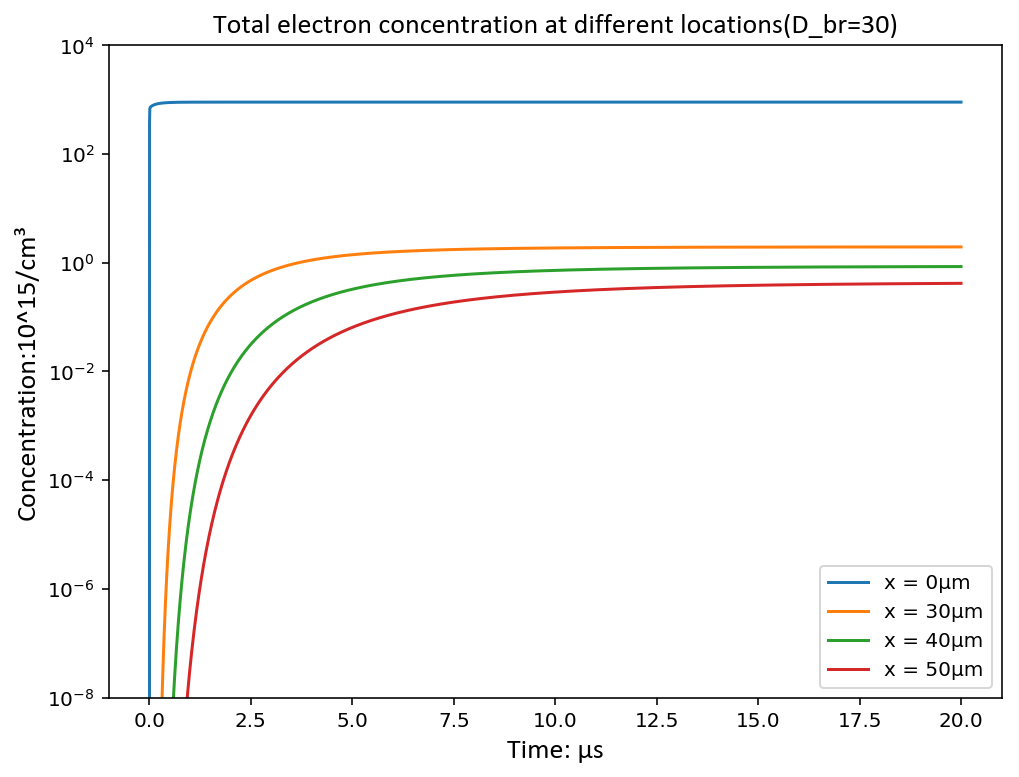

In [11]:
#2D plot for total electrons
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D30_c_0_t)
ax.plot(time, D30_c_30_t)
ax.plot(time, D30_c_40_t)
ax.plot(time, D30_c_50_t)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Concentration:10^15/cm³', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 0μm','x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-8), top = 10**(4))
plt.yscale('log')
plt.title('Total electron concentration at different locations(D_br=30)', fontsize = 14, fontname = 'Calibri')
plt.show()

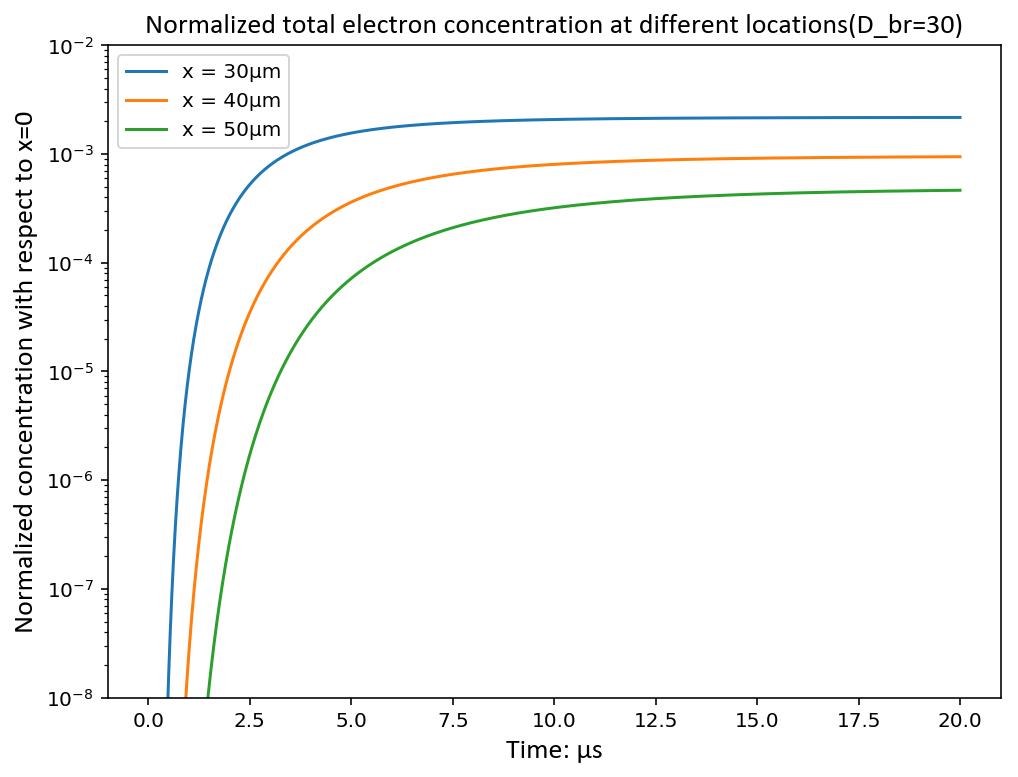

In [14]:
#2D plot for normalized total electrons
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D30_nc_30_t)
ax.plot(time, D30_nc_40_t)
ax.plot(time, D30_nc_50_t)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Normalized concentration with respect to x=0', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-8), top = 10**(-2))
plt.yscale('log')
plt.title('Normalized total electron concentration at different locations(D_br=30)', fontsize = 14, fontname = 'Calibri')
plt.show()

### 1.2 Bright electron

In [15]:
#select corresponding columns at x = 30, 40, 50μm
#apply a lambda function to convert the unit
D30_c_0_b = ((df_br.iloc[:, 0]).apply(lambda x:x/10**3)).tolist()
D30_c_30_b = ((df_br.iloc[:, 30]).apply(lambda x:x/10**3)).tolist()
D30_c_40_b = ((df_br.iloc[:,40]).apply(lambda x:x/10**3)).tolist()
D30_c_50_b = ((df_br.iloc[:, -1]).apply(lambda x:x/10**3)).tolist()
#normalize data x=30,40,50μm with respect to that at x=0
D30_nc_30_b = list_divider(D30_c_30_b, D30_c_0_b)
D30_nc_40_b = list_divider(D30_c_40_b, D30_c_0_b)
D30_nc_50_b = list_divider(D30_c_50_b, D30_c_0_b)

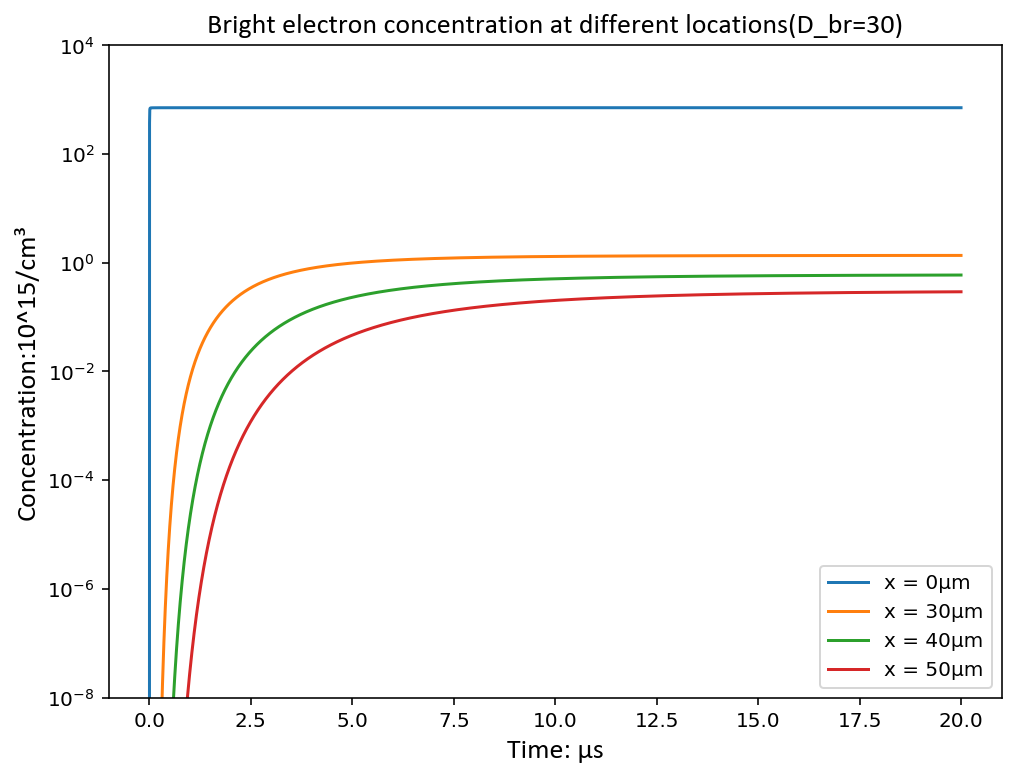

In [16]:
#2D plot for bright electrons
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D30_c_0_b)
ax.plot(time, D30_c_30_b)
ax.plot(time, D30_c_40_b)
ax.plot(time, D30_c_50_b)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Concentration:10^15/cm³', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 0μm','x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-8), top = 10**(4))
plt.yscale('log')
plt.title('Bright electron concentration at different locations(D_br=30)', fontsize = 14, fontname = 'Calibri')
plt.show()

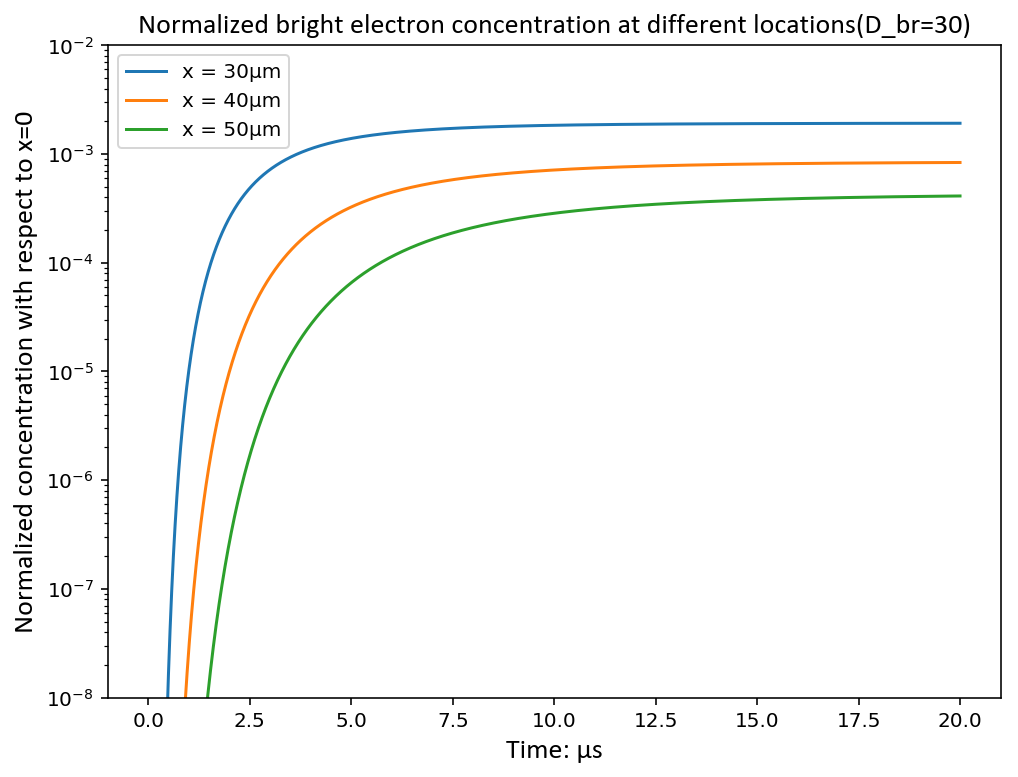

In [17]:
#2D plot for normalized bright electrons
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D30_nc_30_b)
ax.plot(time, D30_nc_40_b)
ax.plot(time, D30_nc_50_b)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Normalized concentration with respect to x=0', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-8), top = 10**(-2))
plt.yscale('log')
plt.title('Normalized bright electron concentration at different locations(D_br=30)', fontsize = 14, fontname = 'Calibri')
plt.show()

### 1.3 Dark electron

In [18]:
#select corresponding columns at x = 30, 40, 50μm
#apply a lambda function to convert the unit
D30_c_0_d = ((df_dr.iloc[:, 0]).apply(lambda x:x/10**3)).tolist()
D30_c_30_d = ((df_dr.iloc[:, 30]).apply(lambda x:x/10**3)).tolist()
D30_c_40_d = ((df_dr.iloc[:,40]).apply(lambda x:x/10**3)).tolist()
D30_c_50_d = ((df_dr.iloc[:, -1]).apply(lambda x:x/10**3)).tolist()
#normalize data x=30,40,50μm with respect to that at x=0
D30_nc_30_d = list_divider(D30_c_30_d, D30_c_0_d)
D30_nc_40_d = list_divider(D30_c_40_d, D30_c_0_d)
D30_nc_50_d = list_divider(D30_c_50_d, D30_c_0_d)

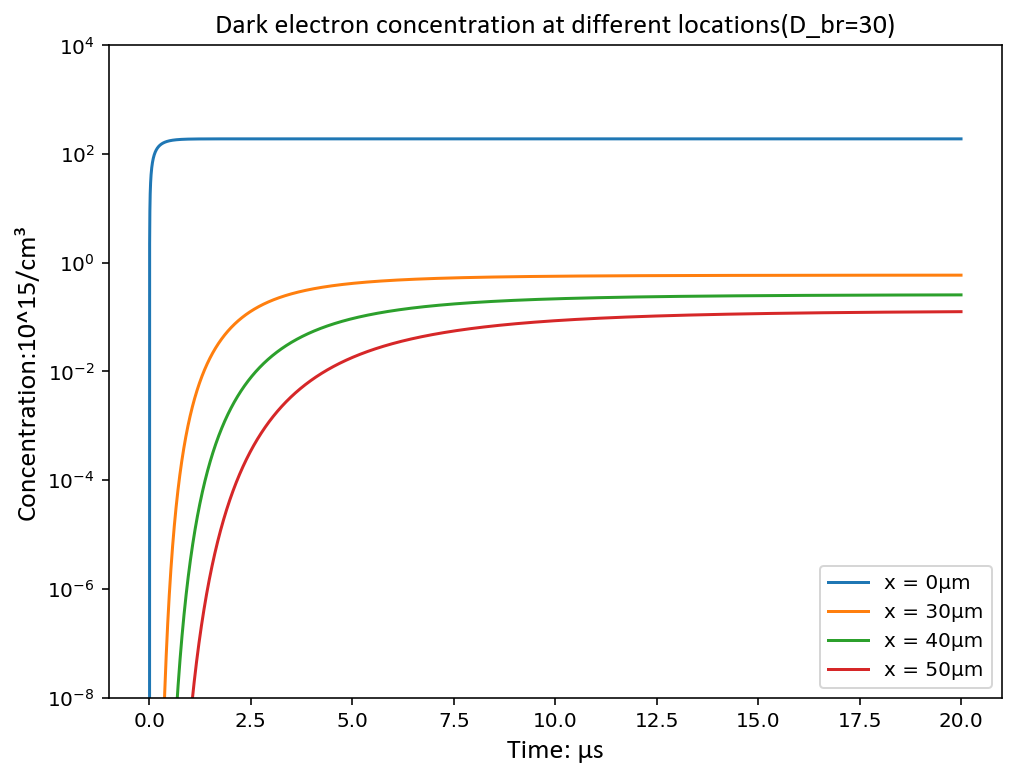

In [19]:
#2D plot for dark electrons
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D30_c_0_d)
ax.plot(time, D30_c_30_d)
ax.plot(time, D30_c_40_d)
ax.plot(time, D30_c_50_d)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Concentration:10^15/cm³', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 0μm','x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-8), top = 10**(4))
plt.yscale('log')
plt.title('Dark electron concentration at different locations(D_br=30)', fontsize = 14, fontname = 'Calibri')
plt.show()

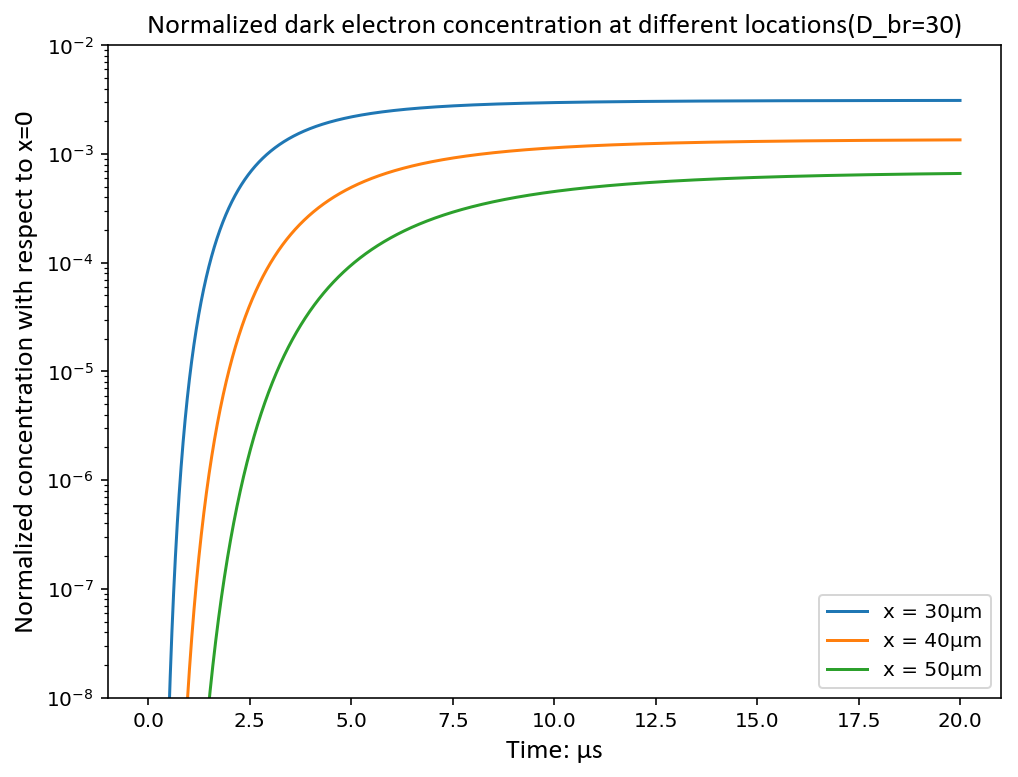

In [20]:
#2D plot for normalized dark electrons
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D30_nc_30_d)
ax.plot(time, D30_nc_40_d)
ax.plot(time, D30_nc_50_d)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Normalized concentration with respect to x=0', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-8), top = 10**(-2))
plt.yscale('log')
plt.title('Normalized dark electron concentration at different locations(D_br=30)', fontsize = 14, fontname = 'Calibri')
plt.show()

## 2. D = 60

### 2.1 Total electron

In [29]:
#select corresponding columns at x = 30, 40, 50μm
#apply a lambda function to convert the unit
D60_c_0_t = ((df_dr.iloc[:, 0] + df_br.iloc[:, 0]).apply(lambda x:x/10**3)).tolist()
D60_c_30_t = ((df_dr.iloc[:, 30] + df_br.iloc[:, 30]).apply(lambda x:x/10**3)).tolist()
D60_c_40_t = ((df_dr.iloc[:, 40] + df_br.iloc[:,40]).apply(lambda x:x/10**3)).tolist()
D60_c_50_t = ((df_dr.iloc[:, -1] + df_br.iloc[:, -1]).apply(lambda x:x/10**3)).tolist()
#normalize data x=30,40,50μm with respect to that at x=0
D60_nc_30_t = list_divider(D60_c_30_t, D60_c_0_t)
D60_nc_40_t = list_divider(D60_c_40_t, D60_c_0_t)
D60_nc_50_t = list_divider(D60_c_50_t, D60_c_0_t)

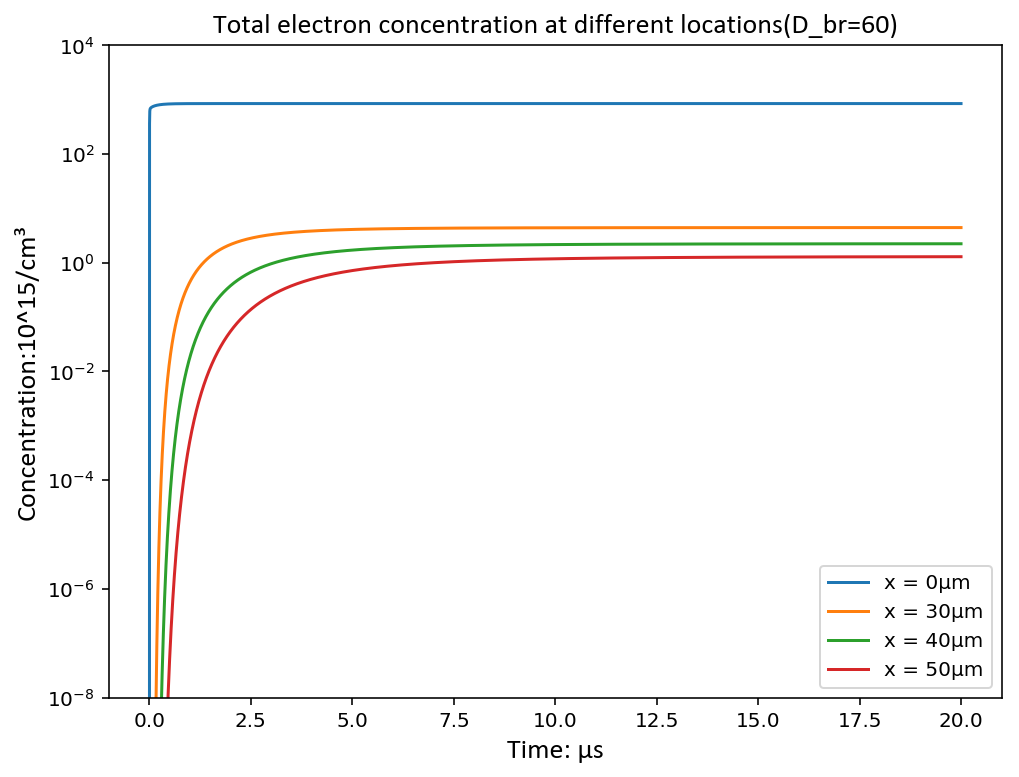

In [30]:
#2D plot for total electrons
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D60_c_0_t)
ax.plot(time, D60_c_30_t)
ax.plot(time, D60_c_40_t)
ax.plot(time, D60_c_50_t)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Concentration:10^15/cm³', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 0μm','x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-8), top = 10**(4))
plt.yscale('log')
plt.title('Total electron concentration at different locations(D_br=60)', fontsize = 14, fontname = 'Calibri')
plt.show()

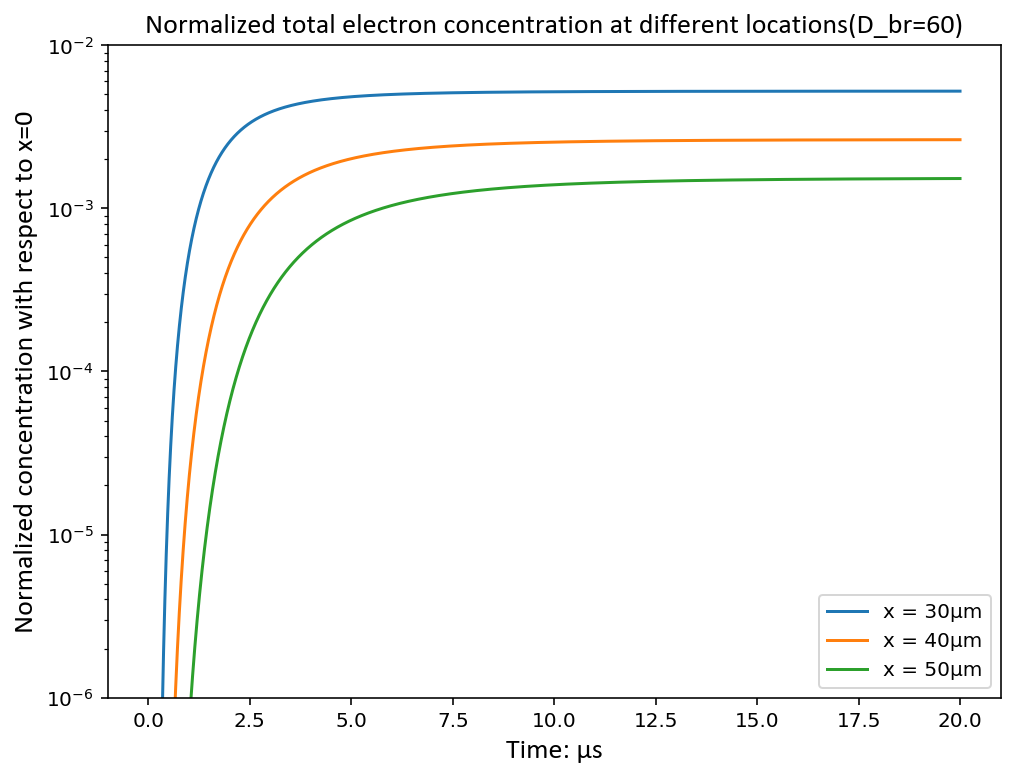

In [33]:
#2D plot for normalized total electrons
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D60_nc_30_t)
ax.plot(time, D60_nc_40_t)
ax.plot(time, D60_nc_50_t)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Normalized concentration with respect to x=0', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-6), top = 10**(-2))
plt.yscale('log')
plt.title('Normalized total electron concentration at different locations(D_br=60)', fontsize = 14, fontname = 'Calibri')
plt.show()

### 2.2 Bright electron

In [34]:
#select corresponding columns at x = 30, 40, 50μm
#apply a lambda function to convert the unit
D60_c_0_b = ((df_br.iloc[:, 0]).apply(lambda x:x/10**3)).tolist()
D60_c_30_b = ((df_br.iloc[:, 30]).apply(lambda x:x/10**3)).tolist()
D60_c_40_b = ((df_br.iloc[:,40]).apply(lambda x:x/10**3)).tolist()
D60_c_50_b = ((df_br.iloc[:, -1]).apply(lambda x:x/10**3)).tolist()
#normalize data x=30,40,50μm with respect to that at x=0
D60_nc_30_b = list_divider(D60_c_30_b, D60_c_0_b)
D60_nc_40_b = list_divider(D60_c_40_b, D60_c_0_b)
D60_nc_50_b = list_divider(D60_c_50_b, D60_c_0_b)

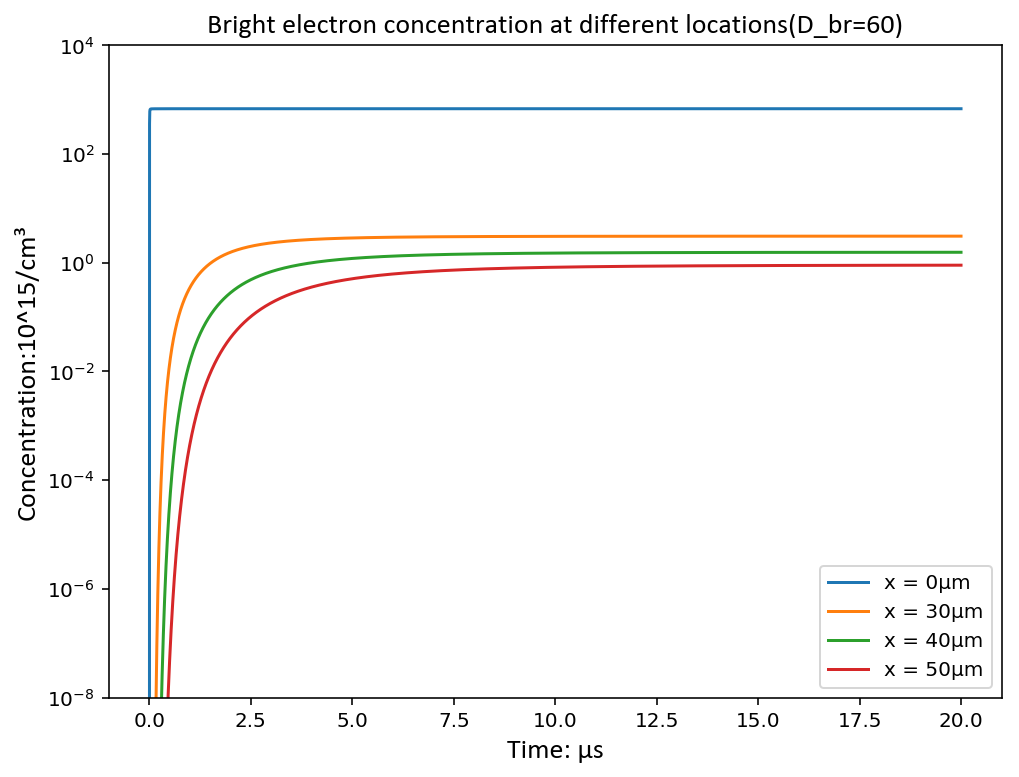

In [35]:
#2D plot for bright electrons
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D60_c_0_b)
ax.plot(time, D60_c_30_b)
ax.plot(time, D60_c_40_b)
ax.plot(time, D60_c_50_b)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Concentration:10^15/cm³', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 0μm','x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-8), top = 10**(4))
plt.yscale('log')
plt.title('Bright electron concentration at different locations(D_br=60)', fontsize = 14, fontname = 'Calibri')
plt.show()

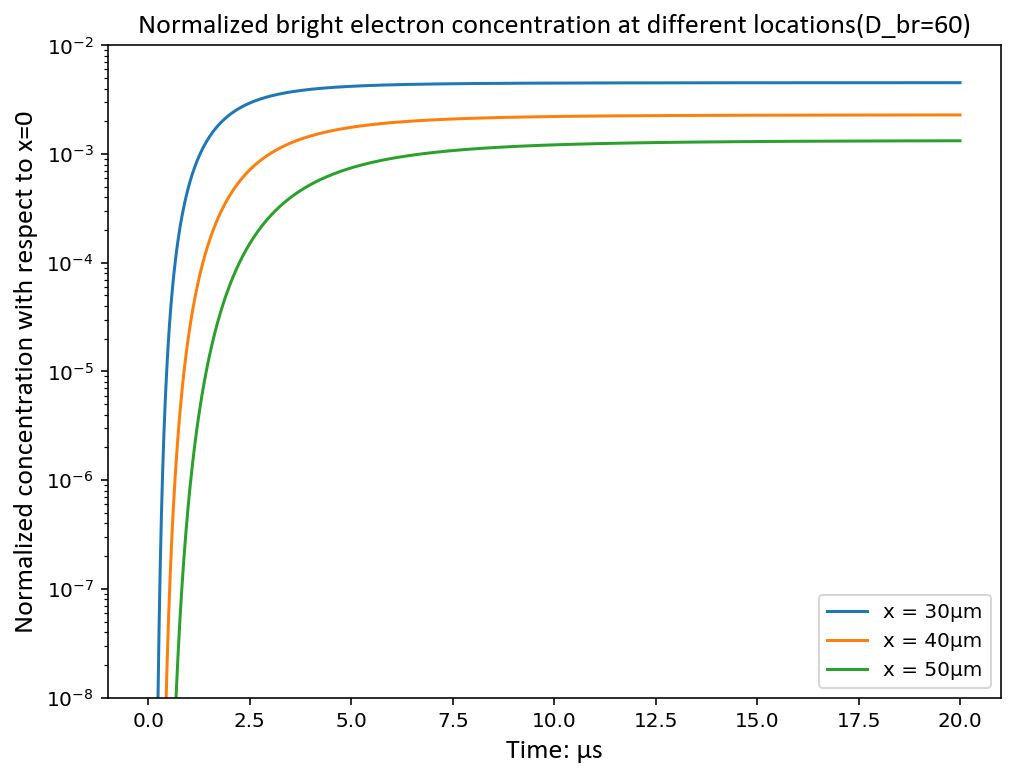

In [36]:
#2D plot for normalized bright electrons
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D60_nc_30_b)
ax.plot(time, D60_nc_40_b)
ax.plot(time, D60_nc_50_b)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Normalized concentration with respect to x=0', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-8), top = 10**(-2))
plt.yscale('log')
plt.title('Normalized bright electron concentration at different locations(D_br=60)', fontsize = 14, fontname = 'Calibri')
plt.show()

### 2.3 Dark electron

In [37]:
#select corresponding columns at x = 30, 40, 50μm
#apply a lambda function to convert the unit
D60_c_0_d = ((df_dr.iloc[:, 0]).apply(lambda x:x/10**3)).tolist()
D60_c_30_d = ((df_dr.iloc[:, 30]).apply(lambda x:x/10**3)).tolist()
D60_c_40_d = ((df_dr.iloc[:,40]).apply(lambda x:x/10**3)).tolist()
D60_c_50_d = ((df_dr.iloc[:, -1]).apply(lambda x:x/10**3)).tolist()
#normalize data x=30,40,50μm with respect to that at x=0
D60_nc_30_d = list_divider(D60_c_30_d, D60_c_0_d)
D60_nc_40_d = list_divider(D60_c_40_d, D60_c_0_d)
D60_nc_50_d = list_divider(D60_c_50_d, D60_c_0_d)

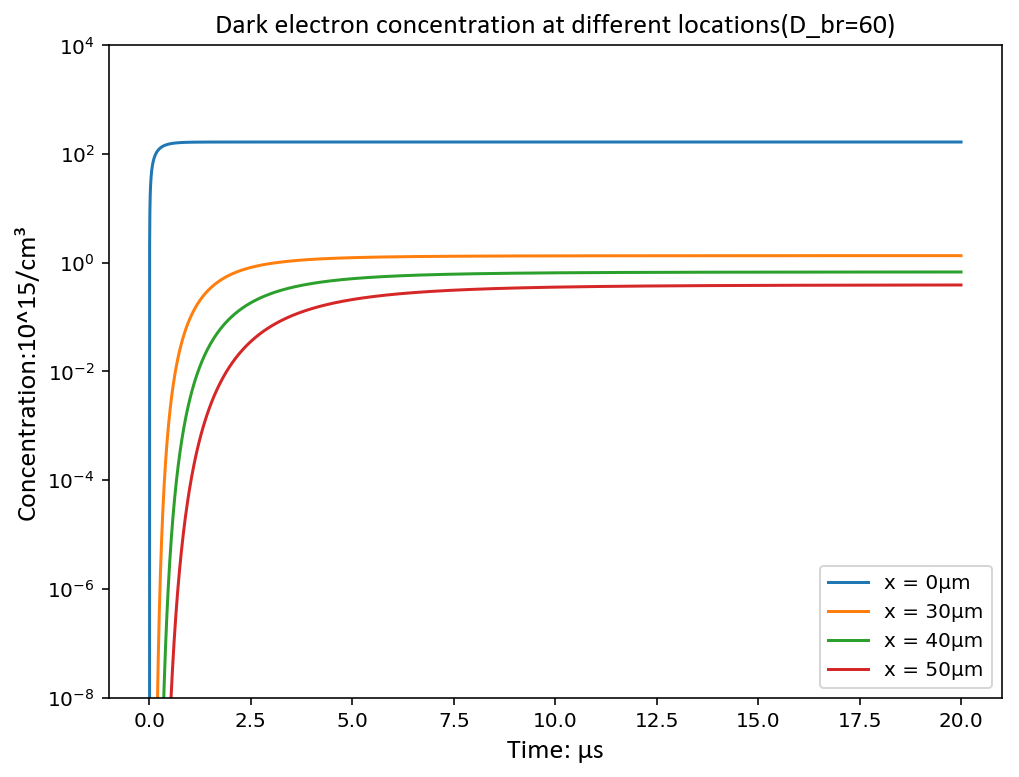

In [38]:
#2D plot for dark electrons
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D60_c_0_d)
ax.plot(time, D60_c_30_d)
ax.plot(time, D60_c_40_d)
ax.plot(time, D60_c_50_d)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Concentration:10^15/cm³', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 0μm','x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-8), top = 10**(4))
plt.yscale('log')
plt.title('Dark electron concentration at different locations(D_br=60)', fontsize = 14, fontname = 'Calibri')
plt.show()

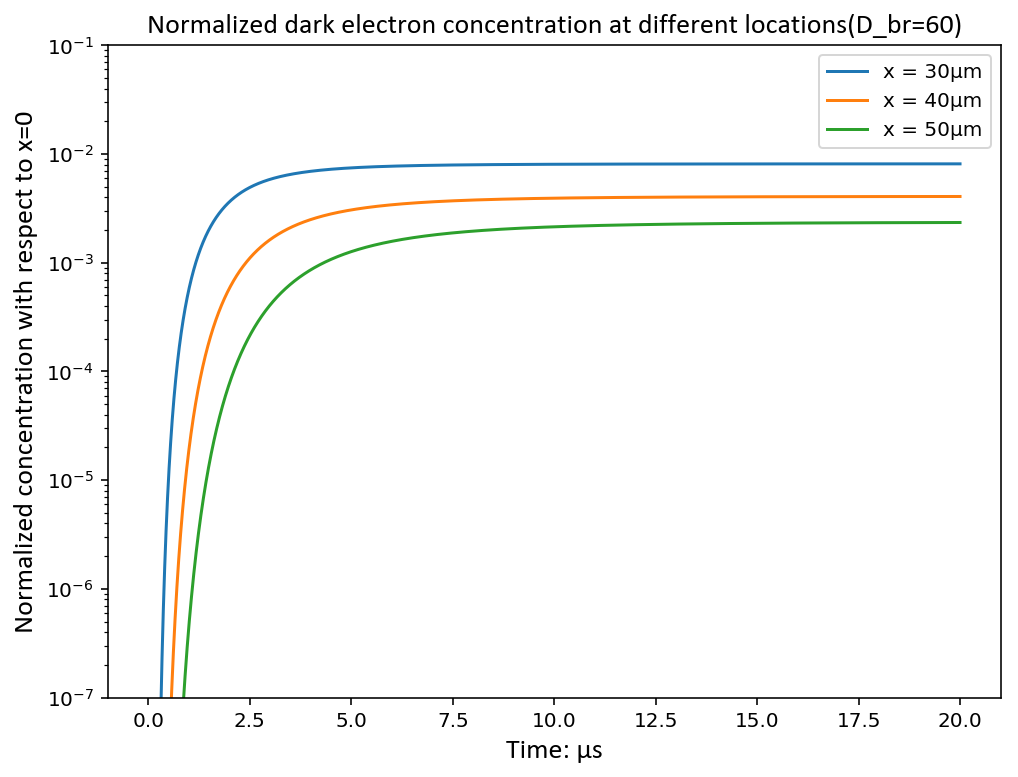

In [41]:
#2D plot for normalized dark electrons
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D60_nc_30_d)
ax.plot(time, D60_nc_40_d)
ax.plot(time, D60_nc_50_d)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Normalized concentration with respect to x=0', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-7), top = 10**(-1))
plt.yscale('log')
plt.title('Normalized dark electron concentration at different locations(D_br=60)', fontsize = 14, fontname = 'Calibri')
plt.show()

## 3. D = 100

## 3.1 Total electron

In [50]:
#select corresponding columns at x = 30, 40, 50μm
#apply a lambda function to convert the unit
D100_c_0_t = ((df_dr.iloc[:, 0] + df_br.iloc[:, 0]).apply(lambda x:x/10**3)).tolist()
D100_c_30_t = ((df_dr.iloc[:, 30] + df_br.iloc[:, 30]).apply(lambda x:x/10**3)).tolist()
D100_c_40_t = ((df_dr.iloc[:, 40] + df_br.iloc[:,40]).apply(lambda x:x/10**3)).tolist()
D100_c_50_t = ((df_dr.iloc[:, -1] + df_br.iloc[:, -1]).apply(lambda x:x/10**3)).tolist()
#normalize data x=30,40,50μm with respect to that at x=0
D100_nc_30_t = list_divider(D100_c_30_t, D100_c_0_t)
D100_nc_40_t = list_divider(D100_c_40_t, D100_c_0_t)
D100_nc_50_t = list_divider(D100_c_50_t, D100_c_0_t)

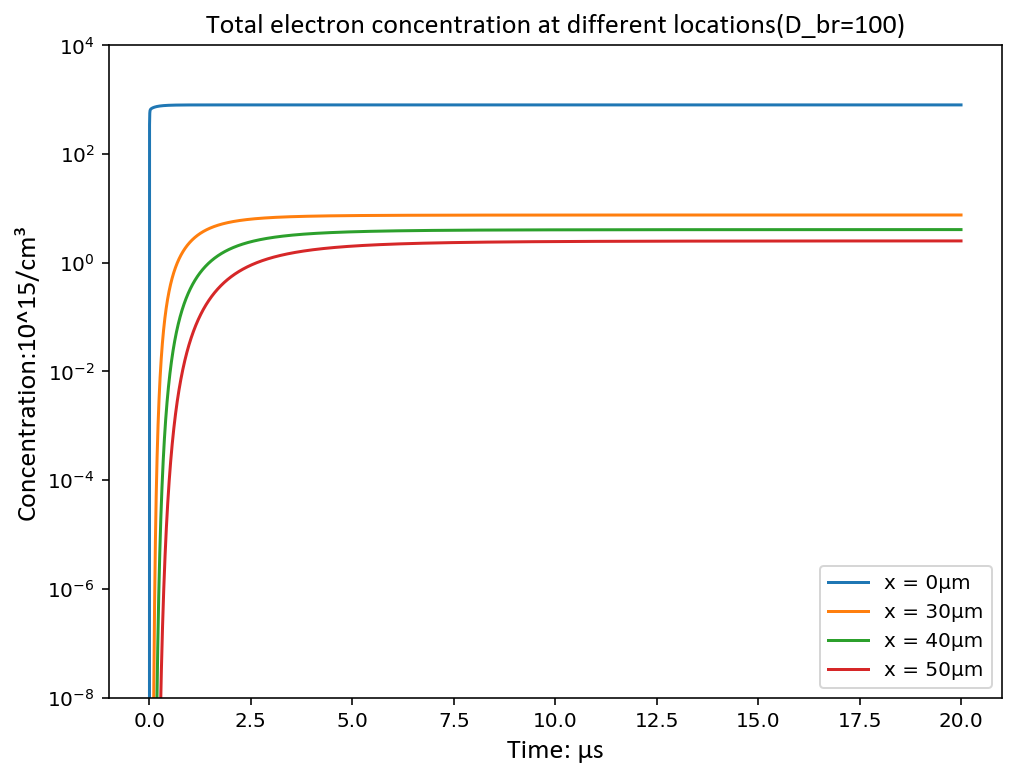

In [51]:
#2D plot for total electrons
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D100_c_0_t)
ax.plot(time, D100_c_30_t)
ax.plot(time, D100_c_40_t)
ax.plot(time, D100_c_50_t)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Concentration:10^15/cm³', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 0μm','x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-8), top = 10**(4))
plt.yscale('log')
plt.title('Total electron concentration at different locations(D_br=100)', fontsize = 14, fontname = 'Calibri')
plt.show()

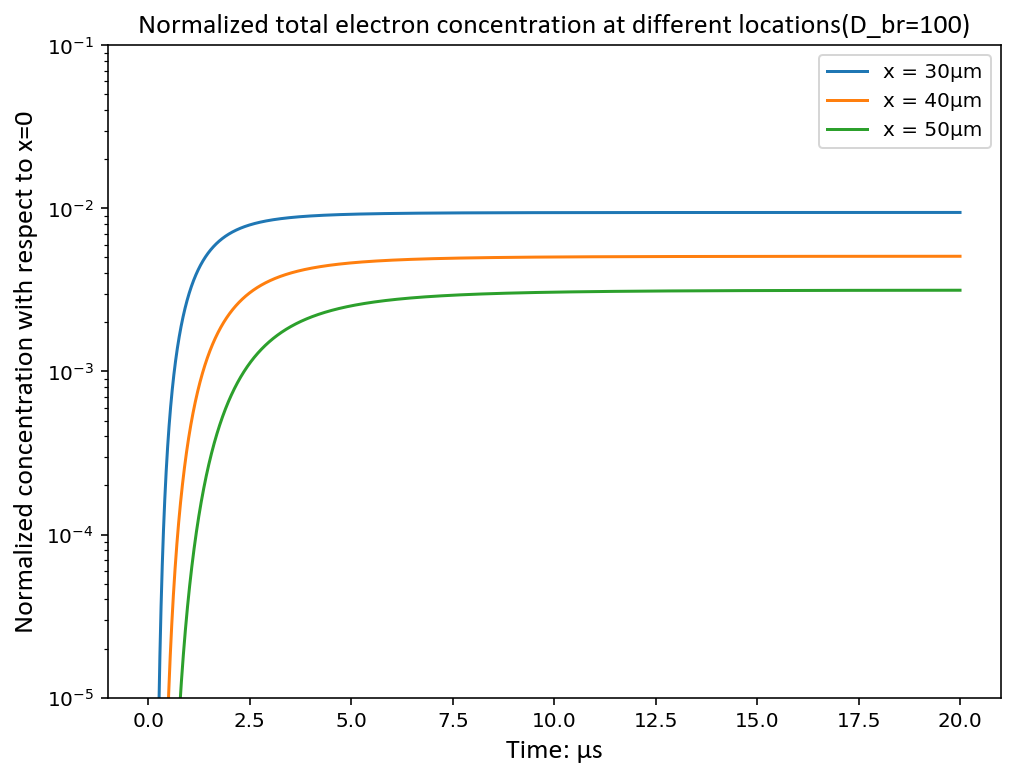

In [53]:
#2D plot for normalized total electrons
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D100_nc_30_t)
ax.plot(time, D100_nc_40_t)
ax.plot(time, D100_nc_50_t)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Normalized concentration with respect to x=0', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-5), top = 10**(-1))
plt.yscale('log')
plt.title('Normalized total electron concentration at different locations(D_br=100)', fontsize = 14, fontname = 'Calibri')
plt.show()

### 3.2 Bright electron

In [54]:
#select corresponding columns at x = 30, 40, 50μm
#apply a lambda function to convert the unit
D100_c_0_b = ((df_br.iloc[:, 0]).apply(lambda x:x/10**3)).tolist()
D100_c_30_b = ((df_br.iloc[:, 30]).apply(lambda x:x/10**3)).tolist()
D100_c_40_b = ((df_br.iloc[:,40]).apply(lambda x:x/10**3)).tolist()
D100_c_50_b = ((df_br.iloc[:, -1]).apply(lambda x:x/10**3)).tolist()
#normalize data x=30,40,50μm with respect to that at x=0
D100_nc_30_b = list_divider(D100_c_30_b, D100_c_0_b)
D100_nc_40_b = list_divider(D100_c_40_b, D100_c_0_b)
D100_nc_50_b = list_divider(D100_c_50_b, D100_c_0_b)

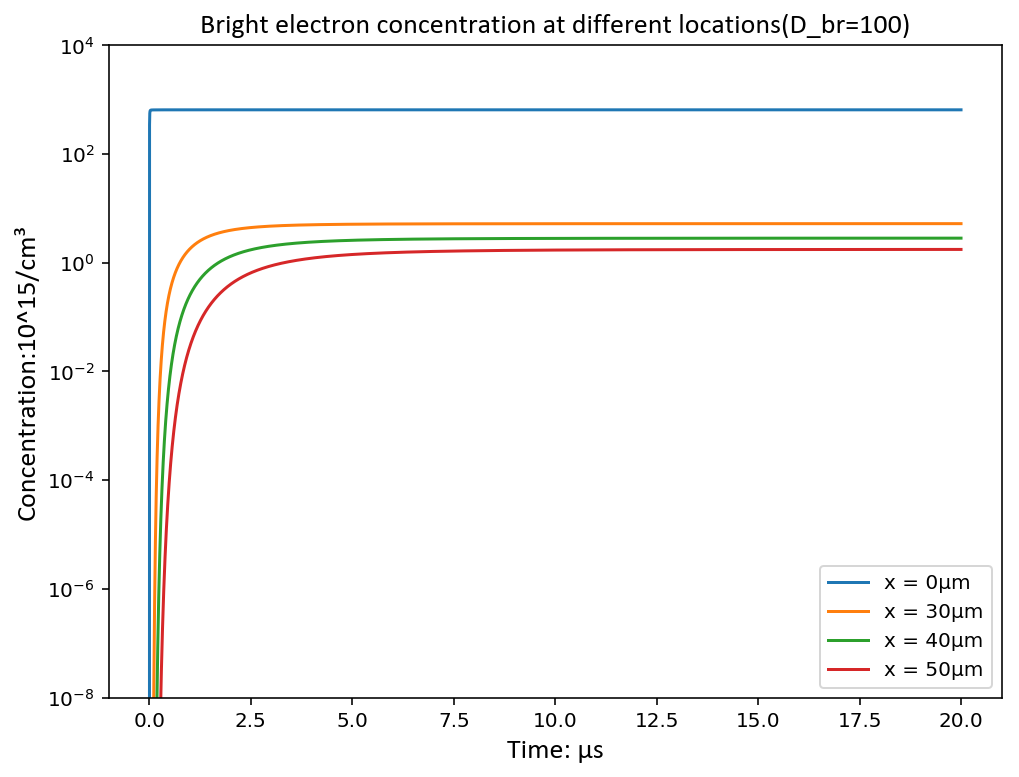

In [55]:
#2D plot for bright electrons
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D100_c_0_b)
ax.plot(time, D100_c_30_b)
ax.plot(time, D100_c_40_b)
ax.plot(time, D100_c_50_b)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Concentration:10^15/cm³', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 0μm','x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-8), top = 10**(4))
plt.yscale('log')
plt.title('Bright electron concentration at different locations(D_br=100)', fontsize = 14, fontname = 'Calibri')
plt.show()

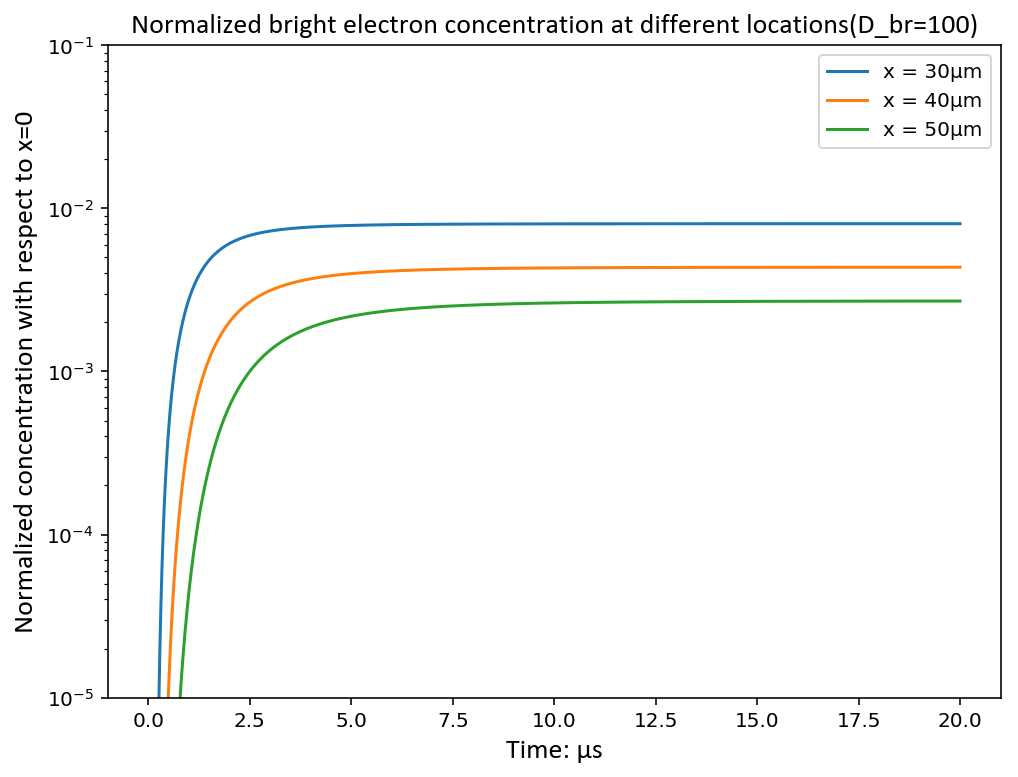

In [56]:
#2D plot for normalized bright electrons
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D100_nc_30_b)
ax.plot(time, D100_nc_40_b)
ax.plot(time, D100_nc_50_b)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Normalized concentration with respect to x=0', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-5), top = 10**(-1))
plt.yscale('log')
plt.title('Normalized bright electron concentration at different locations(D_br=100)', fontsize = 14, fontname = 'Calibri')
plt.show()

### 3.3 Dark electron

In [93]:
#select corresponding columns at x = 30, 40, 50μm
#apply a lambda function to convert the unit
D100_c_0_d = ((df_dr.iloc[:, 0]).apply(lambda x:x/10**3)).tolist()
D100_c_30_d = ((df_dr.iloc[:, 30]).apply(lambda x:x/10**3)).tolist()
D100_c_40_d = ((df_dr.iloc[:,40]).apply(lambda x:x/10**3)).tolist()
D100_c_50_d = ((df_dr.iloc[:, -1]).apply(lambda x:x/10**3)).tolist()
#normalize data x=30,40,50μm with respect to that at x=0
D100_nc_30_d = list_divider(D100_c_30_d, D100_c_0_d)
D100_nc_40_d = list_divider(D100_c_40_d, D100_c_0_d)
D100_nc_50_d = list_divider(D100_c_50_d, D100_c_0_d)

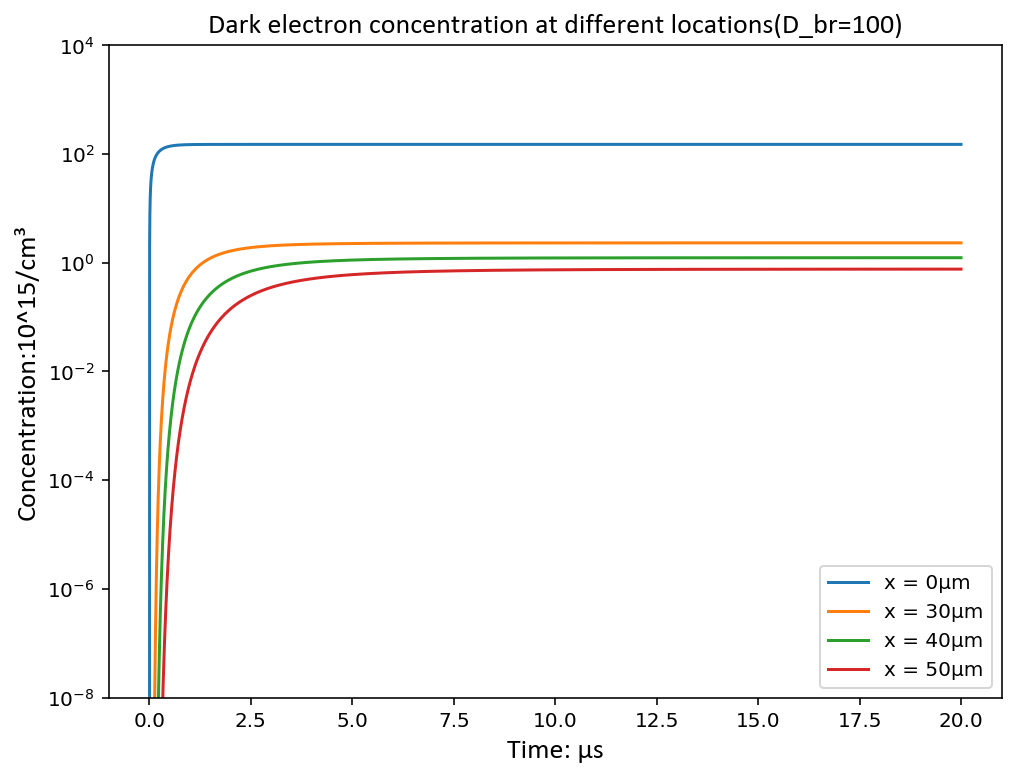

In [94]:
#2D plot for dark electrons
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D100_c_0_d)
ax.plot(time, D100_c_30_d)
ax.plot(time, D100_c_40_d)
ax.plot(time, D100_c_50_d)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Concentration:10^15/cm³', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 0μm','x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-8), top = 10**(4))
plt.yscale('log')
plt.title('Dark electron concentration at different locations(D_br=100)', fontsize = 14, fontname = 'Calibri')
plt.show()

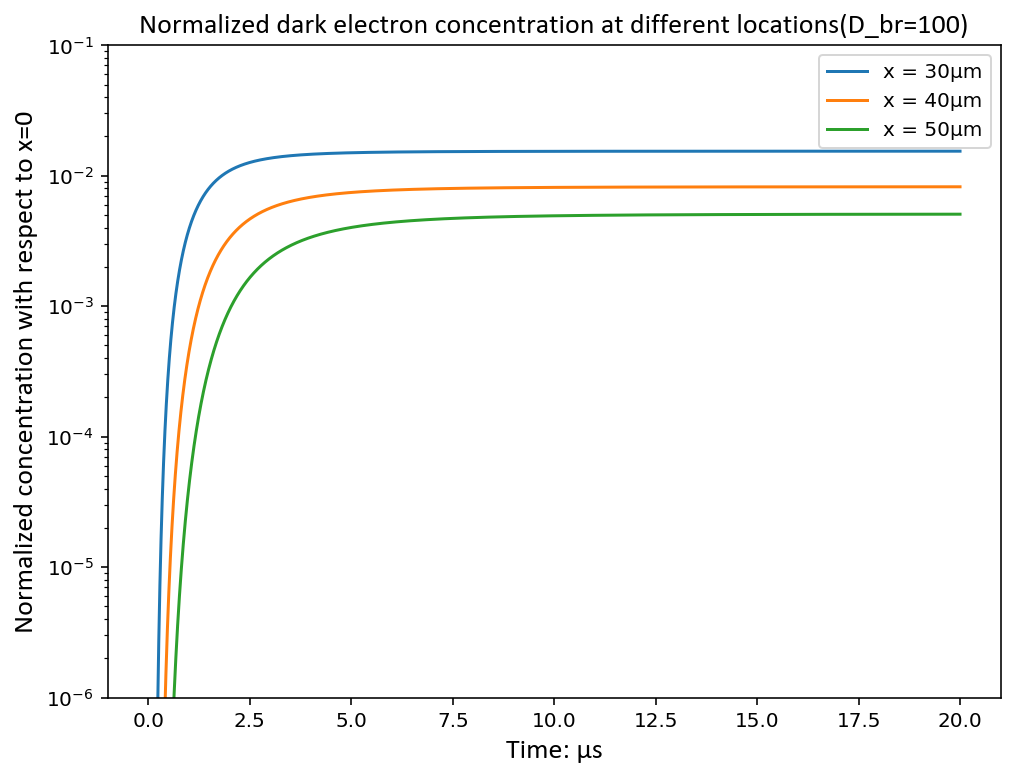

In [95]:
#2D plot for normalized dark electrons
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D100_nc_30_d)
ax.plot(time, D100_nc_40_d)
ax.plot(time, D100_nc_50_d)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Normalized concentration with respect to x=0', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-6), top = 10**(-1))
plt.yscale('log')
plt.title('Normalized dark electron concentration at different locations(D_br=100)', fontsize = 14, fontname = 'Calibri')
plt.show()

## 4. D = 200 

### 4.1 Total electron

In [72]:
#select corresponding columns at x = 30, 40, 50μm
#apply a lambda function to convert the unit
D200_c_0_t = ((df_dr.iloc[:, 0] + df_br.iloc[:, 0]).apply(lambda x:x/10**3)).tolist()
D200_c_30_t = ((df_dr.iloc[:, 30] + df_br.iloc[:, 30]).apply(lambda x:x/10**3)).tolist()
D200_c_40_t = ((df_dr.iloc[:, 40] + df_br.iloc[:,40]).apply(lambda x:x/10**3)).tolist()
D200_c_50_t = ((df_dr.iloc[:, -1] + df_br.iloc[:, -1]).apply(lambda x:x/10**3)).tolist()
#normalize data x=30,40,50μm with respect to that at x=0
D200_nc_30_t = list_divider(D200_c_30_t, D200_c_0_t)
D200_nc_40_t = list_divider(D200_c_40_t, D200_c_0_t)
D200_nc_50_t = list_divider(D200_c_50_t, D200_c_0_t)

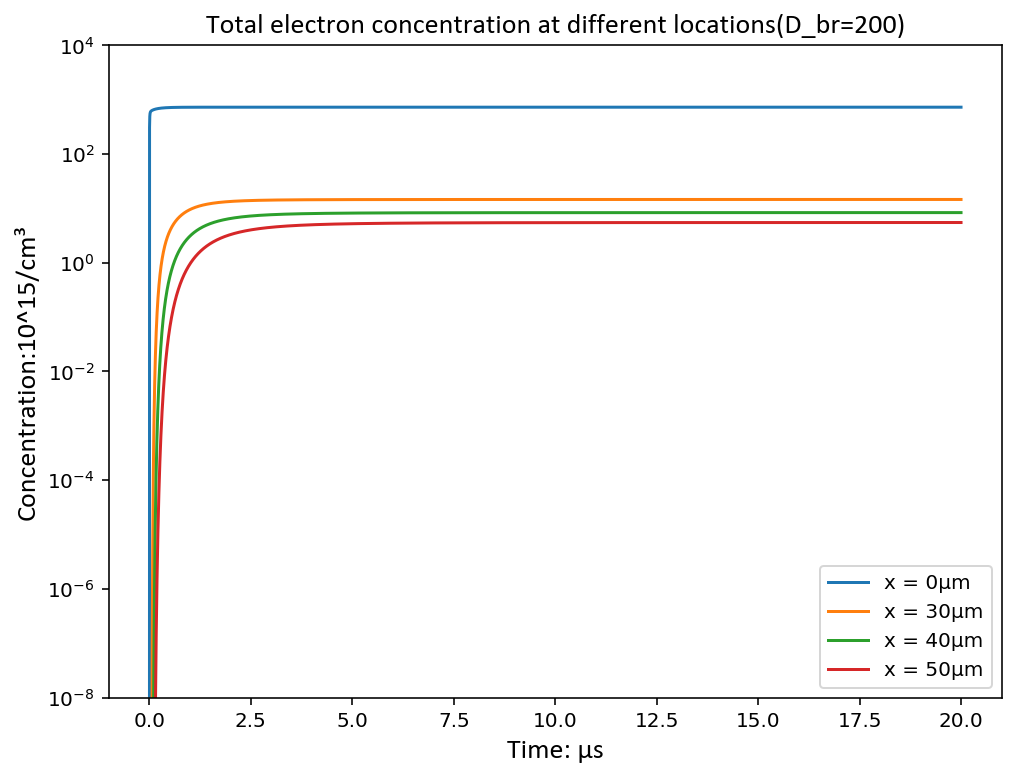

In [73]:
#2D plot for total electrons
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D200_c_0_t)
ax.plot(time, D200_c_30_t)
ax.plot(time, D200_c_40_t)
ax.plot(time, D200_c_50_t)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Concentration:10^15/cm³', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 0μm','x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-8), top = 10**(4))
plt.yscale('log')
plt.title('Total electron concentration at different locations(D_br=200)', fontsize = 14, fontname = 'Calibri')
plt.show()

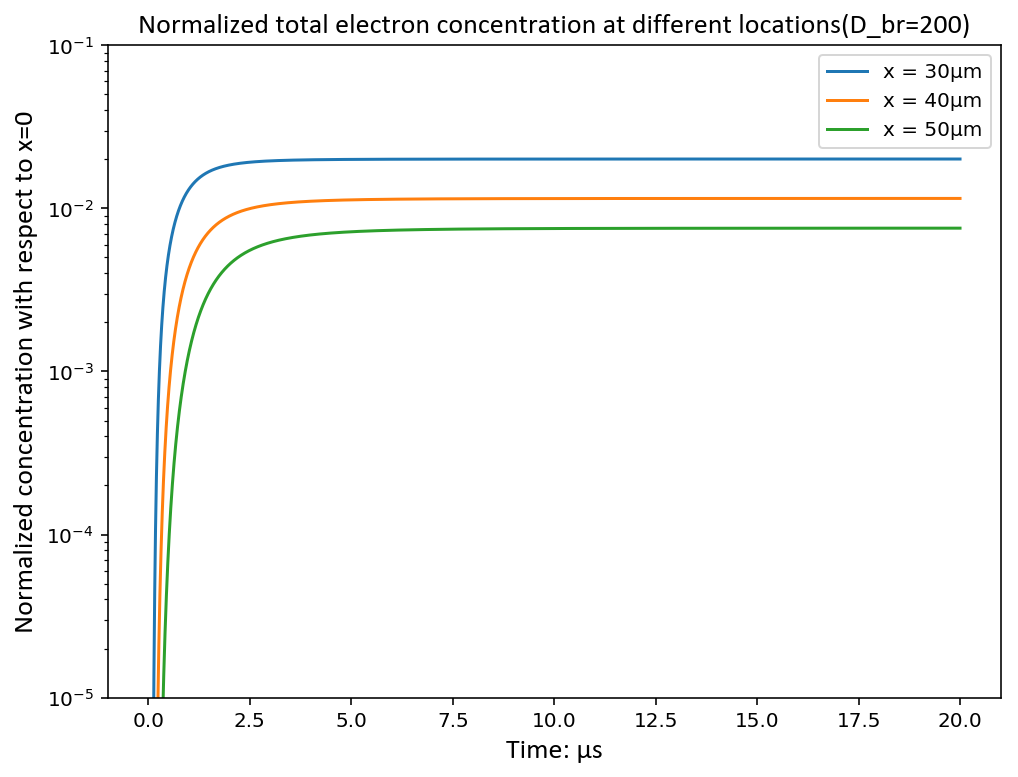

In [74]:
#2D plot for normalized total electrons
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D200_nc_30_t)
ax.plot(time, D200_nc_40_t)
ax.plot(time, D200_nc_50_t)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Normalized concentration with respect to x=0', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-5), top = 10**(-1))
plt.yscale('log')
plt.title('Normalized total electron concentration at different locations(D_br=200)', fontsize = 14, fontname = 'Calibri')
plt.show()

### 4.2 Bright electron

In [75]:
#select corresponding columns at x = 30, 40, 50μm
#apply a lambda function to convert the unit
D200_c_0_b = ((df_br.iloc[:, 0]).apply(lambda x:x/10**3)).tolist()
D200_c_30_b = ((df_br.iloc[:, 30]).apply(lambda x:x/10**3)).tolist()
D200_c_40_b = ((df_br.iloc[:,40]).apply(lambda x:x/10**3)).tolist()
D200_c_50_b = ((df_br.iloc[:, -1]).apply(lambda x:x/10**3)).tolist()
#normalize data x=30,40,50μm with respect to that at x=0
D200_nc_30_b = list_divider(D200_c_30_b, D200_c_0_b)
D200_nc_40_b = list_divider(D200_c_40_b, D200_c_0_b)
D200_nc_50_b = list_divider(D200_c_50_b, D200_c_0_b)

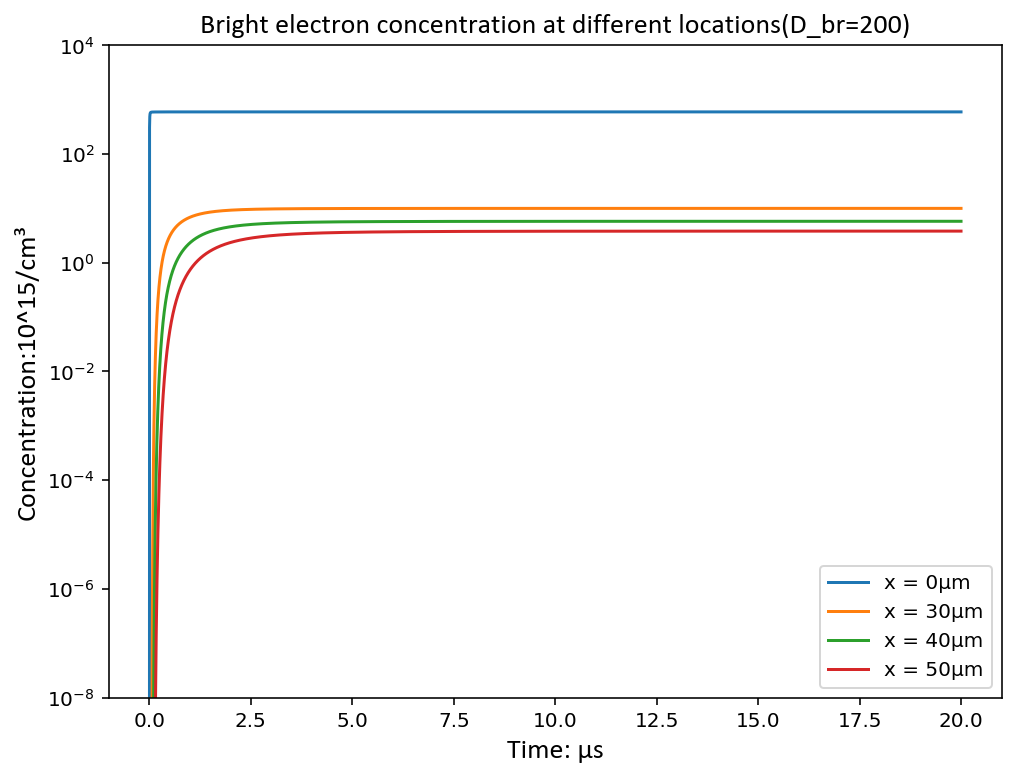

In [76]:
#2D plot for bright electrons
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D200_c_0_b)
ax.plot(time, D200_c_30_b)
ax.plot(time, D200_c_40_b)
ax.plot(time, D200_c_50_b)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Concentration:10^15/cm³', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 0μm','x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-8), top = 10**(4))
plt.yscale('log')
plt.title('Bright electron concentration at different locations(D_br=200)', fontsize = 14, fontname = 'Calibri')
plt.show()

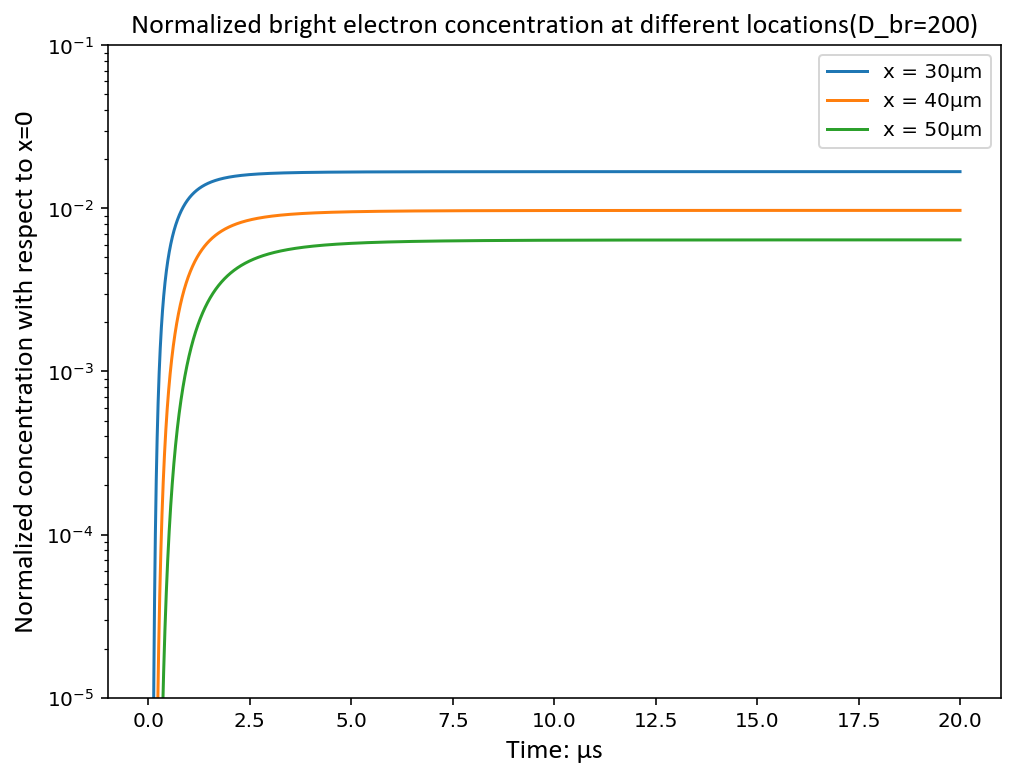

In [77]:
#2D plot for normalized bright electrons
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D200_nc_30_b)
ax.plot(time, D200_nc_40_b)
ax.plot(time, D200_nc_50_b)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Normalized concentration with respect to x=0', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-5), top = 10**(-1))
plt.yscale('log')
plt.title('Normalized bright electron concentration at different locations(D_br=200)', fontsize = 14, fontname = 'Calibri')
plt.show()

### 4.3 Dark electron

In [78]:
#select corresponding columns at x = 30, 40, 50μm
#apply a lambda function to convert the unit
D200_c_0_d = ((df_dr.iloc[:, 0]).apply(lambda x:x/10**3)).tolist()
D200_c_30_d = ((df_dr.iloc[:, 30]).apply(lambda x:x/10**3)).tolist()
D200_c_40_d = ((df_dr.iloc[:,40]).apply(lambda x:x/10**3)).tolist()
D200_c_50_d = ((df_dr.iloc[:, -1]).apply(lambda x:x/10**3)).tolist()
#normalize data x=30,40,50μm with respect to that at x=0
D200_nc_30_d = list_divider(D200_c_30_d, D200_c_0_d)
D200_nc_40_d = list_divider(D200_c_40_d, D200_c_0_d)
D200_nc_50_d = list_divider(D200_c_50_d, D200_c_0_d)

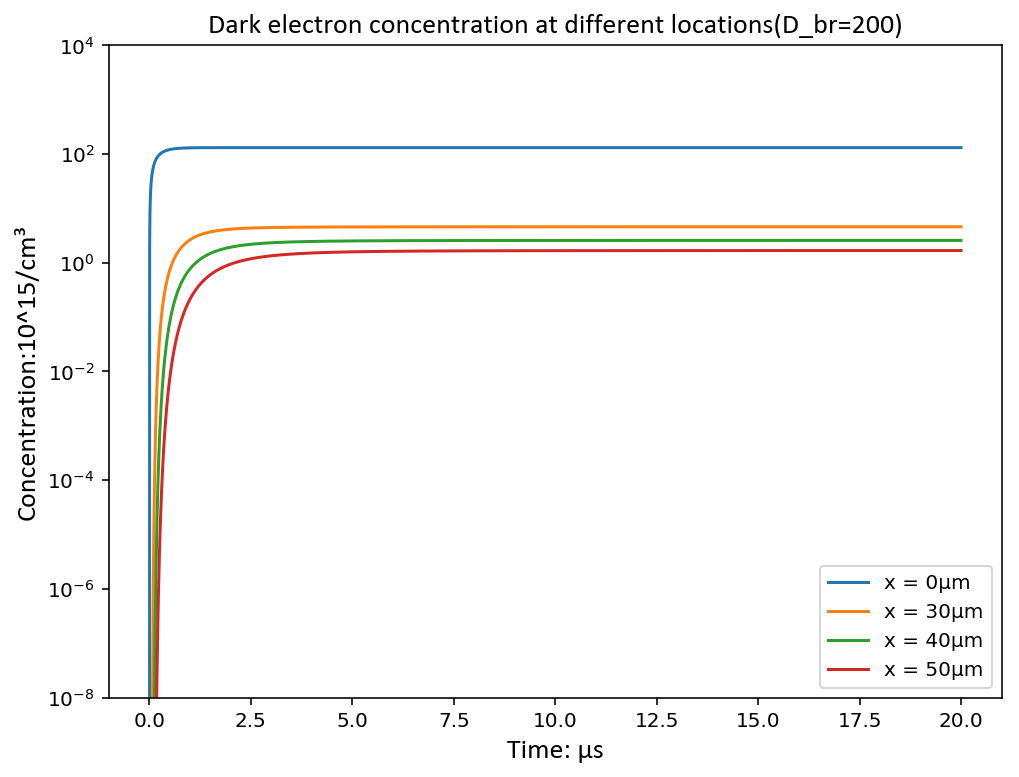

In [83]:
#2D plot for dark electrons
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D200_c_0_d)
ax.plot(time, D200_c_30_d)
ax.plot(time, D200_c_40_d)
ax.plot(time, D200_c_50_d)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Concentration:10^15/cm³', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 0μm','x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-8), top = 10**(4))
plt.yscale('log')
plt.title('Dark electron concentration at different locations(D_br=200)', fontsize = 14, fontname = 'Calibri')
plt.show()

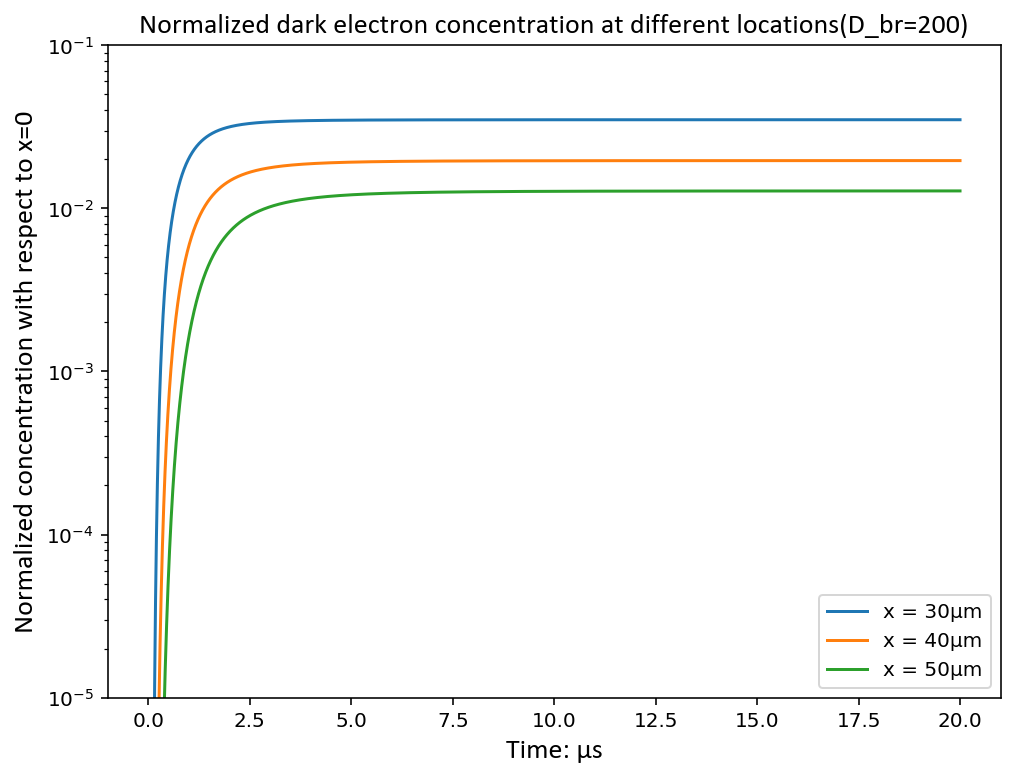

In [84]:
#2D plot for normalized dark electrons
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
time = [2*10**(-3)*i for i in range(10000)]
fig, ax = plt.subplots(figsize = (8,6))
ax.plot(time, D200_nc_30_d)
ax.plot(time, D200_nc_40_d)
ax.plot(time, D200_nc_50_d)
ax.set_xlabel('Time: μs', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Normalized concentration with respect to x=0', fontsize = 14, fontname = 'Calibri')
ax.legend(['x = 30μm','x = 40μm','x = 50μm'])
plt.ylim(bottom = 10**(-5), top = 10**(-1))
plt.yscale('log')
plt.title('Normalized dark electron concentration at different locations(D_br=200)', fontsize = 14, fontname = 'Calibri')
plt.show()

## Compare the saturation level when use different D

### 0. x=0

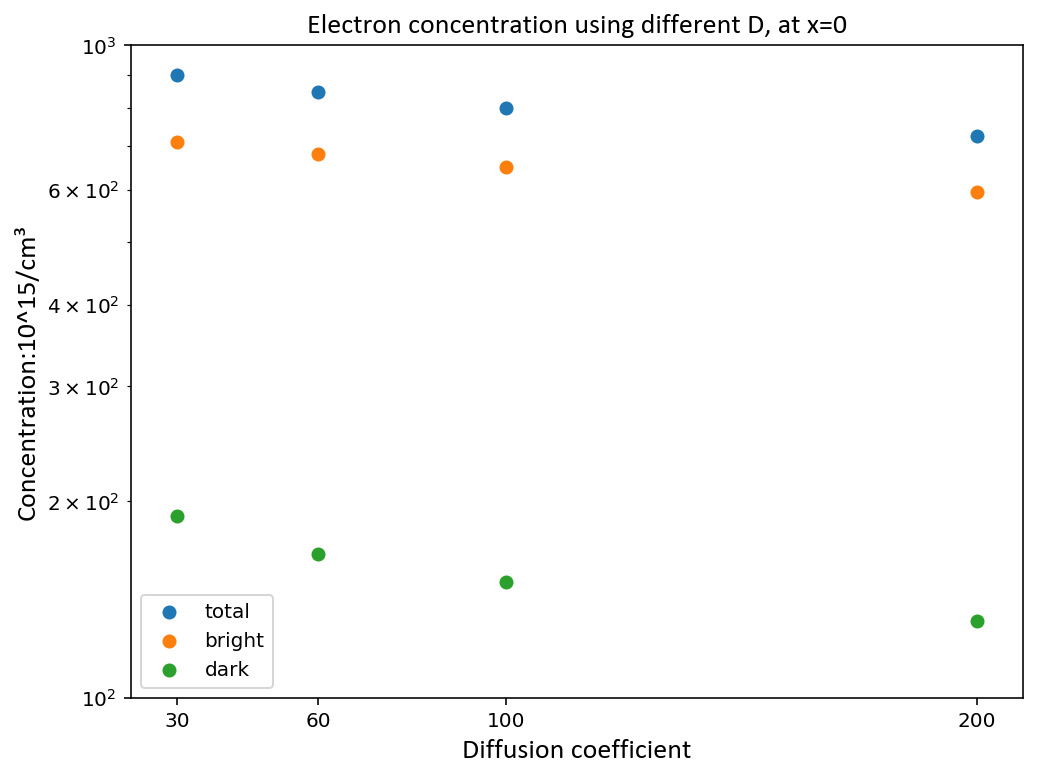

In [97]:
#2D plot for total/bright/dark electrons using different D
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots(figsize = (8,6))
D = [30,60,100,200]
ax.scatter(D, [D30_c_0_t[-1], D60_c_0_t[-1], D100_c_0_t[-1], D200_c_0_t[-1]])
ax.scatter(D, [D30_c_0_b[-1], D60_c_0_b[-1], D100_c_0_b[-1], D200_c_0_b[-1]])
ax.scatter(D, [D30_c_0_d[-1], D60_c_0_d[-1], D100_c_0_d[-1], D200_c_0_d[-1]])
ax.set_xticks(D)
ax.set_xlabel('Diffusion coefficient', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Concentration:10^15/cm³', fontsize = 14, fontname = 'Calibri')
ax.legend(['total','bright','dark'])
plt.ylim(bottom = 10**(2), top = 10**(3))
plt.yscale('log')
plt.title('Electron concentration using different D, at x=0', fontsize = 14, fontname = 'Calibri')
plt.show()

### 1. x = 30μm

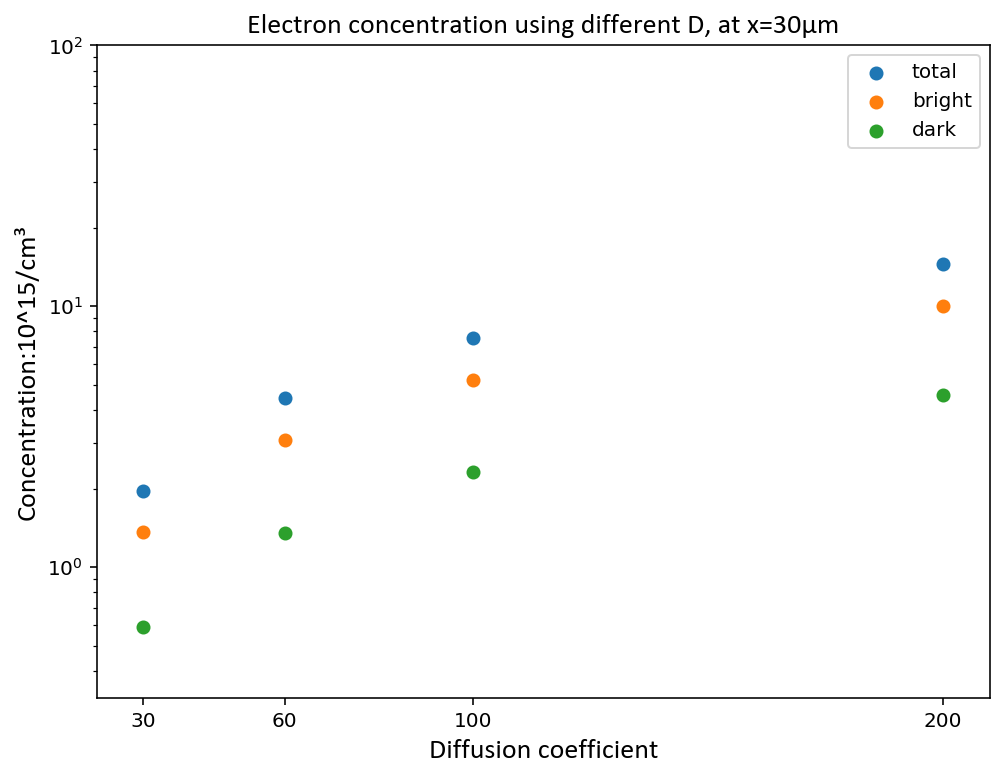

In [100]:
#2D plot for total/bright/dark electrons using different D
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots(figsize = (8,6))
D = [30,60,100,200]
ax.scatter(D, [D30_c_30_t[-1], D60_c_30_t[-1], D100_c_30_t[-1], D200_c_30_t[-1]])
ax.scatter(D, [D30_c_30_b[-1], D60_c_30_b[-1], D100_c_30_b[-1], D200_c_30_b[-1]])
ax.scatter(D, [D30_c_30_d[-1], D60_c_30_d[-1], D100_c_30_d[-1], D200_c_30_d[-1]])
ax.set_xticks(D)
ax.set_xlabel('Diffusion coefficient', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Concentration:10^15/cm³', fontsize = 14, fontname = 'Calibri')
ax.legend(['total','bright','dark'])
plt.ylim(bottom = 10**(-0.5), top = 10**(2))
plt.yscale('log')
plt.title('Electron concentration using different D, at x=30μm', fontsize = 14, fontname = 'Calibri')
plt.show()

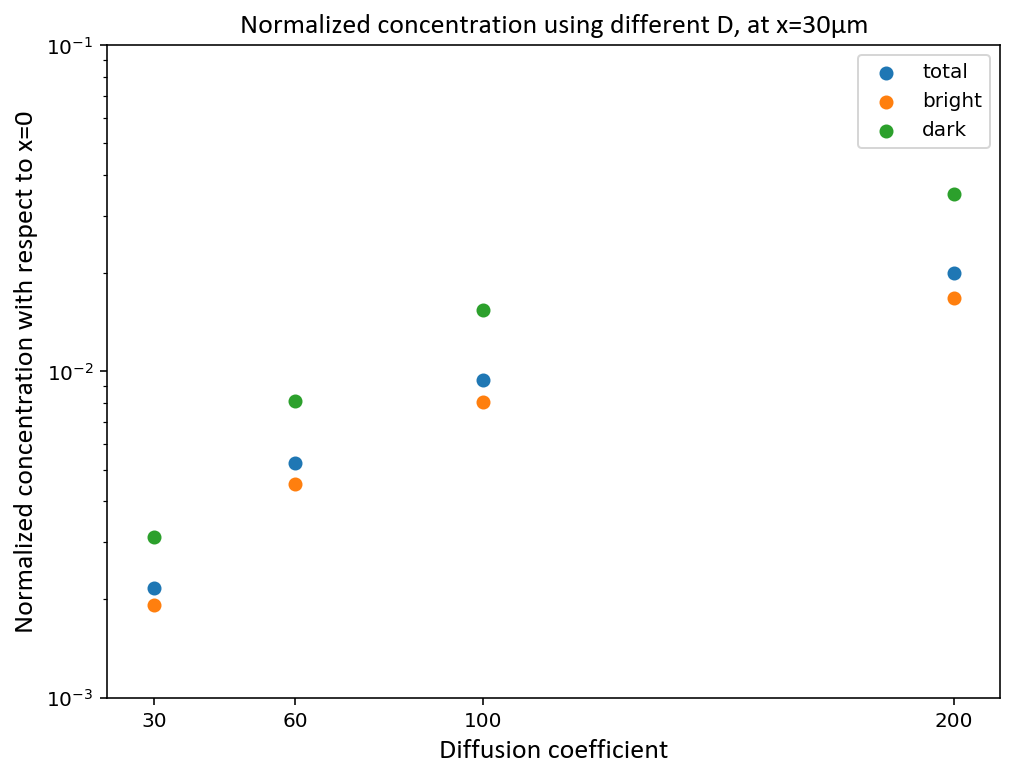

In [102]:
#2D plot for normalized total/bright/dark electrons using different D
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots(figsize = (8,6))
D = [30,60,100,200]
ax.scatter(D, [D30_nc_30_t[-1], D60_nc_30_t[-1], D100_nc_30_t[-1], D200_nc_30_t[-1]])
ax.scatter(D, [D30_nc_30_b[-1], D60_nc_30_b[-1], D100_nc_30_b[-1], D200_nc_30_b[-1]])
ax.scatter(D, [D30_nc_30_d[-1], D60_nc_30_d[-1], D100_nc_30_d[-1], D200_nc_30_d[-1]])
ax.set_xticks(D)
ax.set_xlabel('Diffusion coefficient', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Normalized concentration with respect to x=0', fontsize = 14, fontname = 'Calibri')
ax.legend(['total','bright','dark'])
plt.ylim(bottom = 10**(-3), top = 10**(-1))
plt.yscale('log')
plt.title('Normalized concentration using different D, at x=30μm', fontsize = 14, fontname = 'Calibri')
plt.show()

### 2. x=40μm

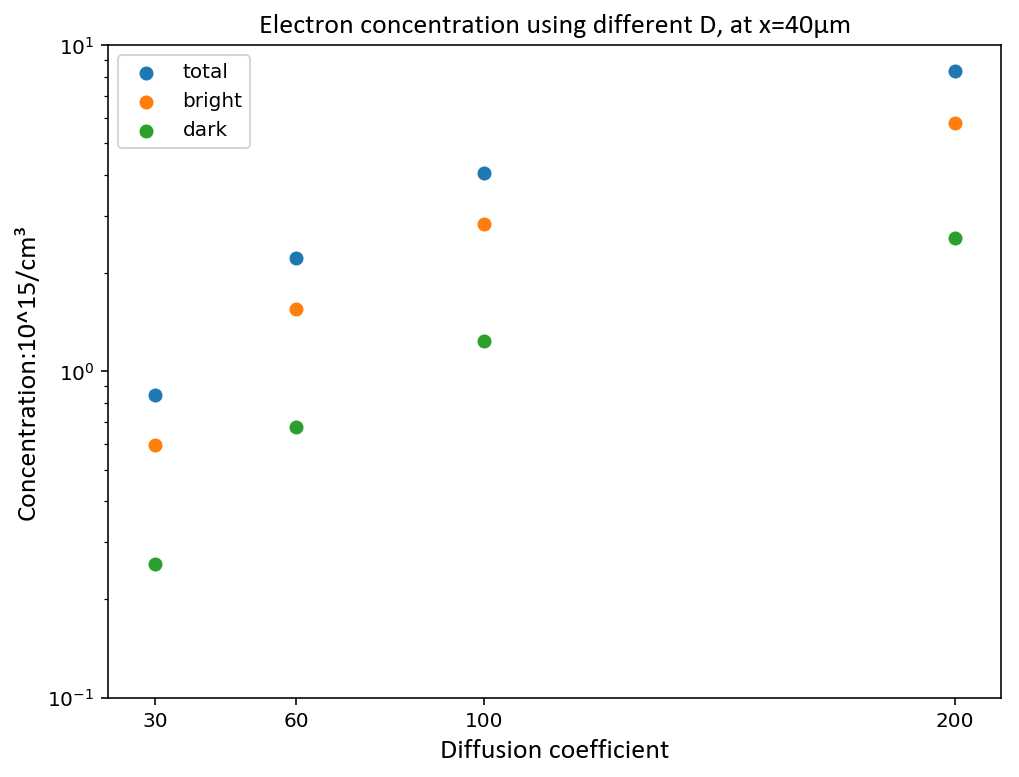

In [104]:
#2D plot for total/bright/dark electrons using different D
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots(figsize = (8,6))
D = [30,60,100,200]
ax.scatter(D, [D30_c_40_t[-1], D60_c_40_t[-1], D100_c_40_t[-1], D200_c_40_t[-1]])
ax.scatter(D, [D30_c_40_b[-1], D60_c_40_b[-1], D100_c_40_b[-1], D200_c_40_b[-1]])
ax.scatter(D, [D30_c_40_d[-1], D60_c_40_d[-1], D100_c_40_d[-1], D200_c_40_d[-1]])
ax.set_xticks(D)
ax.set_xlabel('Diffusion coefficient', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Concentration:10^15/cm³', fontsize = 14, fontname = 'Calibri')
ax.legend(['total','bright','dark'])
plt.ylim(bottom = 10**(-1), top = 10**(1))
plt.yscale('log')
plt.title('Electron concentration using different D, at x=40μm', fontsize = 14, fontname = 'Calibri')
plt.show()

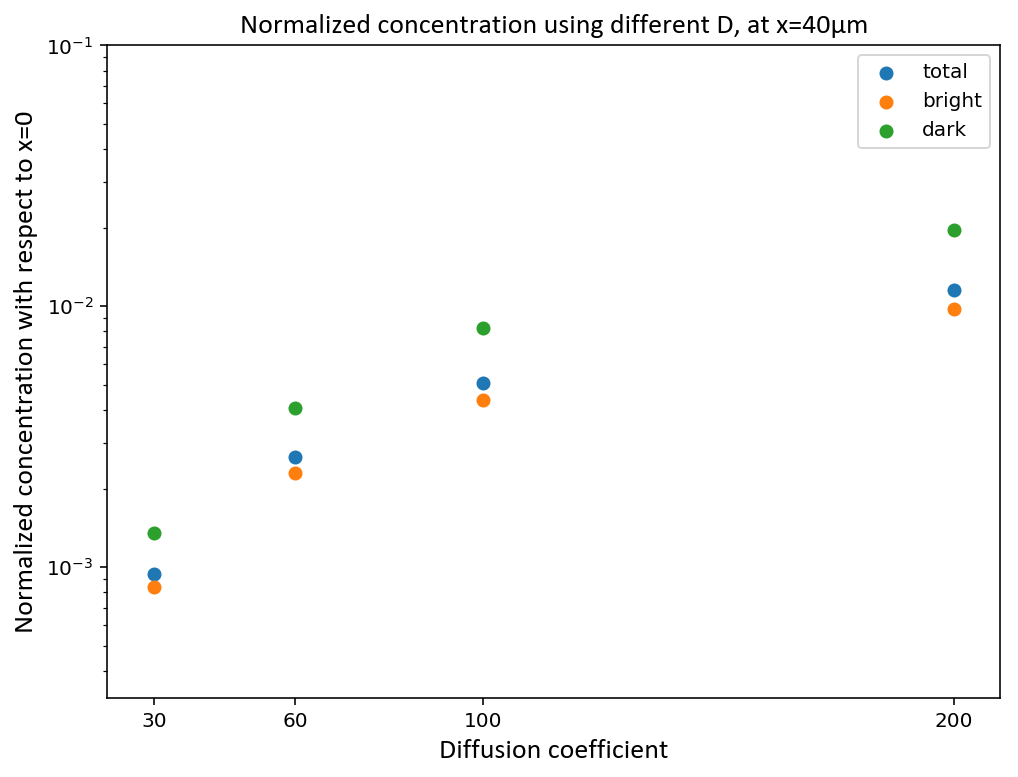

In [110]:
#2D plot for normalized total/bright/dark electrons using different D
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots(figsize = (8,6))
D = [30,60,100,200]
ax.scatter(D, [D30_nc_40_t[-1], D60_nc_40_t[-1], D100_nc_40_t[-1], D200_nc_40_t[-1]])
ax.scatter(D, [D30_nc_40_b[-1], D60_nc_40_b[-1], D100_nc_40_b[-1], D200_nc_40_b[-1]])
ax.scatter(D, [D30_nc_40_d[-1], D60_nc_40_d[-1], D100_nc_40_d[-1], D200_nc_40_d[-1]])
ax.set_xticks(D)
ax.set_xlabel('Diffusion coefficient', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Normalized concentration with respect to x=0', fontsize = 14, fontname = 'Calibri')
ax.legend(['total','bright','dark'])
plt.ylim(bottom = 10**(-3.5), top = 10**(-1))
plt.yscale('log')
plt.title('Normalized concentration using different D, at x=40μm', fontsize = 14, fontname = 'Calibri')
plt.show()

### 3. x=50μm

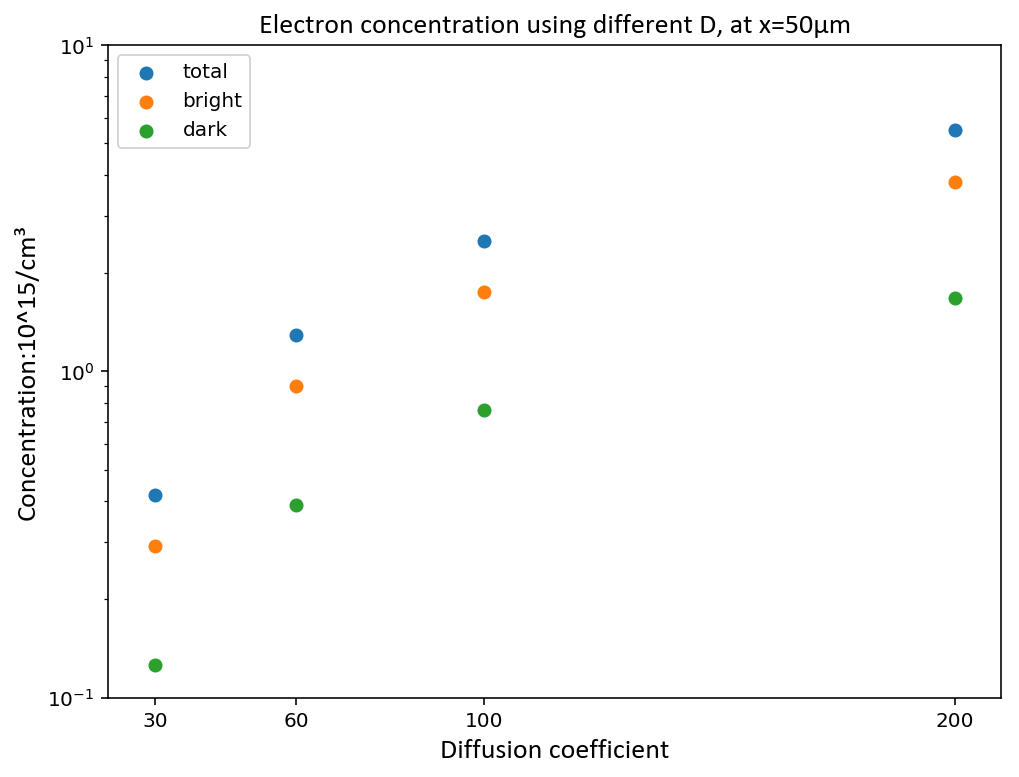

In [107]:
#2D plot for total/bright/dark electrons using different D
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots(figsize = (8,6))
D = [30,60,100,200]
ax.scatter(D, [D30_c_50_t[-1], D60_c_50_t[-1], D100_c_50_t[-1], D200_c_50_t[-1]])
ax.scatter(D, [D30_c_50_b[-1], D60_c_50_b[-1], D100_c_50_b[-1], D200_c_50_b[-1]])
ax.scatter(D, [D30_c_50_d[-1], D60_c_50_d[-1], D100_c_50_d[-1], D200_c_50_d[-1]])
ax.set_xticks(D)
ax.set_xlabel('Diffusion coefficient', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Concentration:10^15/cm³', fontsize = 14, fontname = 'Calibri')
ax.legend(['total','bright','dark'])
plt.ylim(bottom = 10**(-1), top = 10**(1))
plt.yscale('log')
plt.title('Electron concentration using different D, at x=50μm', fontsize = 14, fontname = 'Calibri')
plt.show()

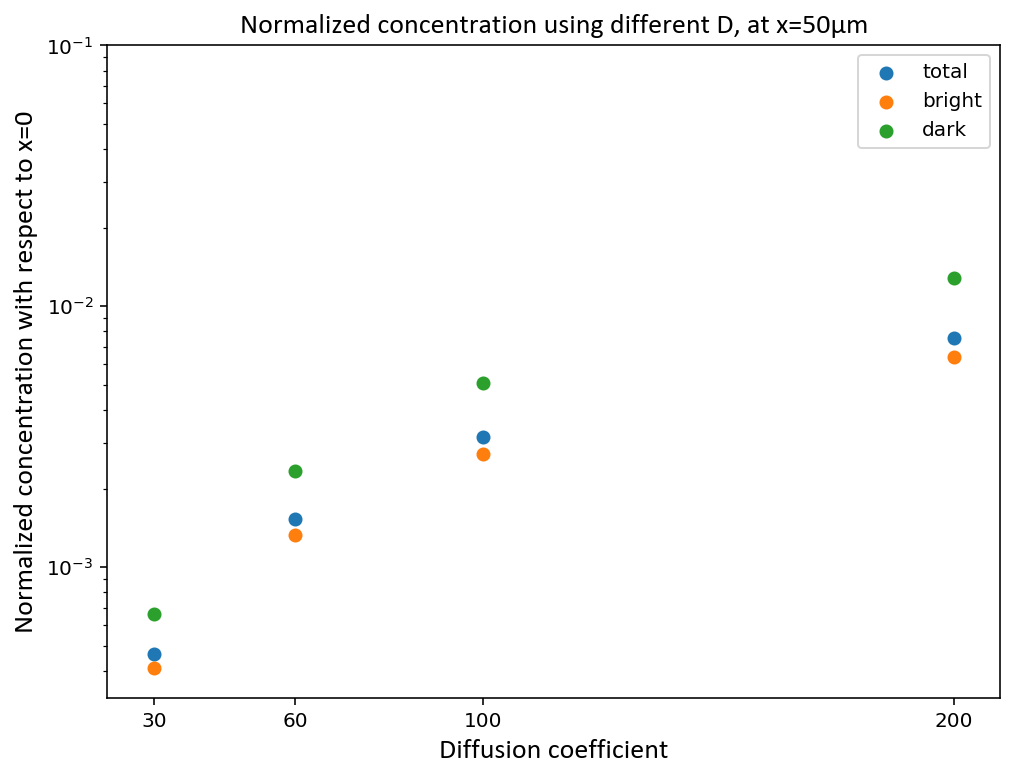

In [109]:
#2D plot for normalized total/bright/dark electrons using different D
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots(figsize = (8,6))
D = [30,60,100,200]
ax.scatter(D, [D30_nc_50_t[-1], D60_nc_50_t[-1], D100_nc_50_t[-1], D200_nc_50_t[-1]])
ax.scatter(D, [D30_nc_50_b[-1], D60_nc_50_b[-1], D100_nc_50_b[-1], D200_nc_50_b[-1]])
ax.scatter(D, [D30_nc_50_d[-1], D60_nc_50_d[-1], D100_nc_50_d[-1], D200_nc_50_d[-1]])
ax.set_xticks(D)
ax.set_xlabel('Diffusion coefficient', fontsize = 14, fontname = 'Calibri')
ax.set_ylabel('Normalized concentration with respect to x=0', fontsize = 14, fontname = 'Calibri')
ax.legend(['total','bright','dark'])
plt.ylim(bottom = 10**(-3.5), top = 10**(-1))
plt.yscale('log')
plt.title('Normalized concentration using different D, at x=50μm', fontsize = 14, fontname = 'Calibri')
plt.show()